In [132]:
####
# imports
####

# lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import re
import math # for ceil
from scipy import stats # for pearsonr
import seaborn as sns # for pairplot

In [133]:
####
# global variable
####

# When presenting to the class, we probably don't want to output a bunch of
# debug output.
debug = True

# Set the style to 'dark_background'
plt.style.use('dark_background')

In [134]:
####
# Load the games.csv file, convert and clean it into a useful form.
# Display some of the data to check that it loaded correctly
####

fileLocation = "games.csv"

# if the file exists
if (os.path.isfile(fileLocation)):
  # read in the file
  # will have to change path -> look up how to mount google drive and get path to file for this
  file = pd.read_csv(fileLocation)
else:
  # download the file directly
  import gdown
  url = "" # add the games.csv here
  output = 'games.csv'
  gdown.download(url, output, quiet=False)
  file = pd.read_csv('games.csv')

if (debug):
  # print columns and shape
  print(file.columns)
  print(file.shape)

# make it into a dataframe for easier manipulation and clean up the data
df = pd.DataFrame(file)

if (debug):
  # print out the information of the dataframe
  df.info()


Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')
(71716, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71716 entries, 0 to 71715
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       71716 non-null  int64  
 1   Name               

In [135]:
# bc we have 39 columns, we need to see all of them to analyze data -> set max columns to 39
pd.set_option("display.max_columns", 39)

if (debug):
  df.head()  # print out the first 5 rows of the dataframe

# based on info, remove, about the game, support lang, full audio lang, reviews, header image
# support url, email, screenshots and movies for now
# add cases -> drop only if these columns exist
dropList = [
    "About the game",
    "Supported languages",
    "Full audio languages",
    "Reviews",
    "Header image",
    "Website",
    "Support url",
    "Support email",
    "Screenshots",
    "Movies",
]

# drop the columns only if they exist, if not, ignore
df.drop(dropList, axis=1, inplace=True, errors="ignore")

if (debug):
  # print out the columns and shape of the dataframe
  print("Total cols: ", df.columns)
  print("Shape after drop: ", df.shape)

  # print out first 5 rows of the dataframe
  df.head()

Total cols:  Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'Windows', 'Mac', 'Linux',
       'Metacritic score', 'Metacritic url', 'User score', 'Positive',
       'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Notes',
       'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags'],
      dtype='object')
Shape after drop:  (71716, 29)


In [136]:
# make dataframe to avoid our master dataframe from being changed
# and for now, we only want to get Genres, Names, AppID, Metacritic score for now

df2 = df[["AppID", "Name", "Estimated owners", "Genres", "Metacritic score"]]

# remove all rows with a Metacritic Score of 0
df2 = df2[df2['Metacritic score'] > 0]

# print out the first 5 rows of the dataframe
print("The first 5 rows of our data:")
df2.head()

The first 5 rows of our data:


AppID                     Name  Estimated owners               Genres   
10  1026420                   WARSAW     20000 - 50000            Indie,RPG  \
15    22670   Alien Breed 3: Descent   200000 - 500000               Action   
42   231330      Deadfall Adventures   100000 - 200000     Action,Adventure   
44   897820  Reigns: Game of Thrones    50000 - 100000  Adventure,Indie,RPG   
66    12140                Max Payne  500000 - 1000000               Action   

    Metacritic score  
10                62  
15                64  
42                53  
44                84  
66                89

In [137]:
####
# create a list of all the genres
####

GenresColumn = df2["Genres"]  # get the column Genres

# parse each row in column and parse each genre in each row delim by , and store it in a list
GenresList = []

for row in GenresColumn:
    # print(row)
    row = str(row)
    row = row.split("\n")
    for genre in row:
        genre = genre.split(",")
        for g in genre:
            GenresList.append(g)

# we will then process the list ->
# remove duplicate genres
GenresList = list(dict.fromkeys(GenresList))
# sort from A-Z
GenresList.sort()
# and remove those that nan as it cause error
GenresList.remove("nan")

print(GenresList, " size: ", len(GenresList))

['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Gore', 'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Violent']  size:  16


In [138]:
####
# For each genre, create a list of all the games that belong to that genre
####

generasDf = []
for genre in GenresList:
  dfAccounting = pd.DataFrame().reindex_like(df2).dropna()
  for dfIndex, row in enumerate(df2.index):
    if (genre in str(df2['Genres'][row])):
      dfAccounting.loc[len(dfAccounting)] = df2.iloc[dfIndex]
  generasDf.append(dfAccounting)
  if (debug):
    # display the first 5 rows of the dataframe
    print("The first 5 rows of the dataframe for ", genre)
    dfAccounting.head()

The first 5 rows of the dataframe for  Action
The first 5 rows of the dataframe for  Adventure
The first 5 rows of the dataframe for  Casual
The first 5 rows of the dataframe for  Early Access
The first 5 rows of the dataframe for  Free to Play
The first 5 rows of the dataframe for  Gore
The first 5 rows of the dataframe for  Indie
The first 5 rows of the dataframe for  Massively Multiplayer
The first 5 rows of the dataframe for  Nudity
The first 5 rows of the dataframe for  RPG
The first 5 rows of the dataframe for  Racing
The first 5 rows of the dataframe for  Sexual Content
The first 5 rows of the dataframe for  Simulation
The first 5 rows of the dataframe for  Sports
The first 5 rows of the dataframe for  Strategy
The first 5 rows of the dataframe for  Violent


In [139]:
# print the numbers of games in each genre
for i, genre in enumerate(GenresList):
  print(genre, ":", len(generasDf[i]))
  

Action : 1908
Adventure : 1653
Casual : 462
Early Access : 7
Free to Play : 92
Gore : 2
Indie : 2070
Massively Multiplayer : 75
Nudity : 3
RPG : 802
Racing : 121
Sexual Content : 2
Simulation : 551
Sports : 113
Strategy : 924
Violent : 7


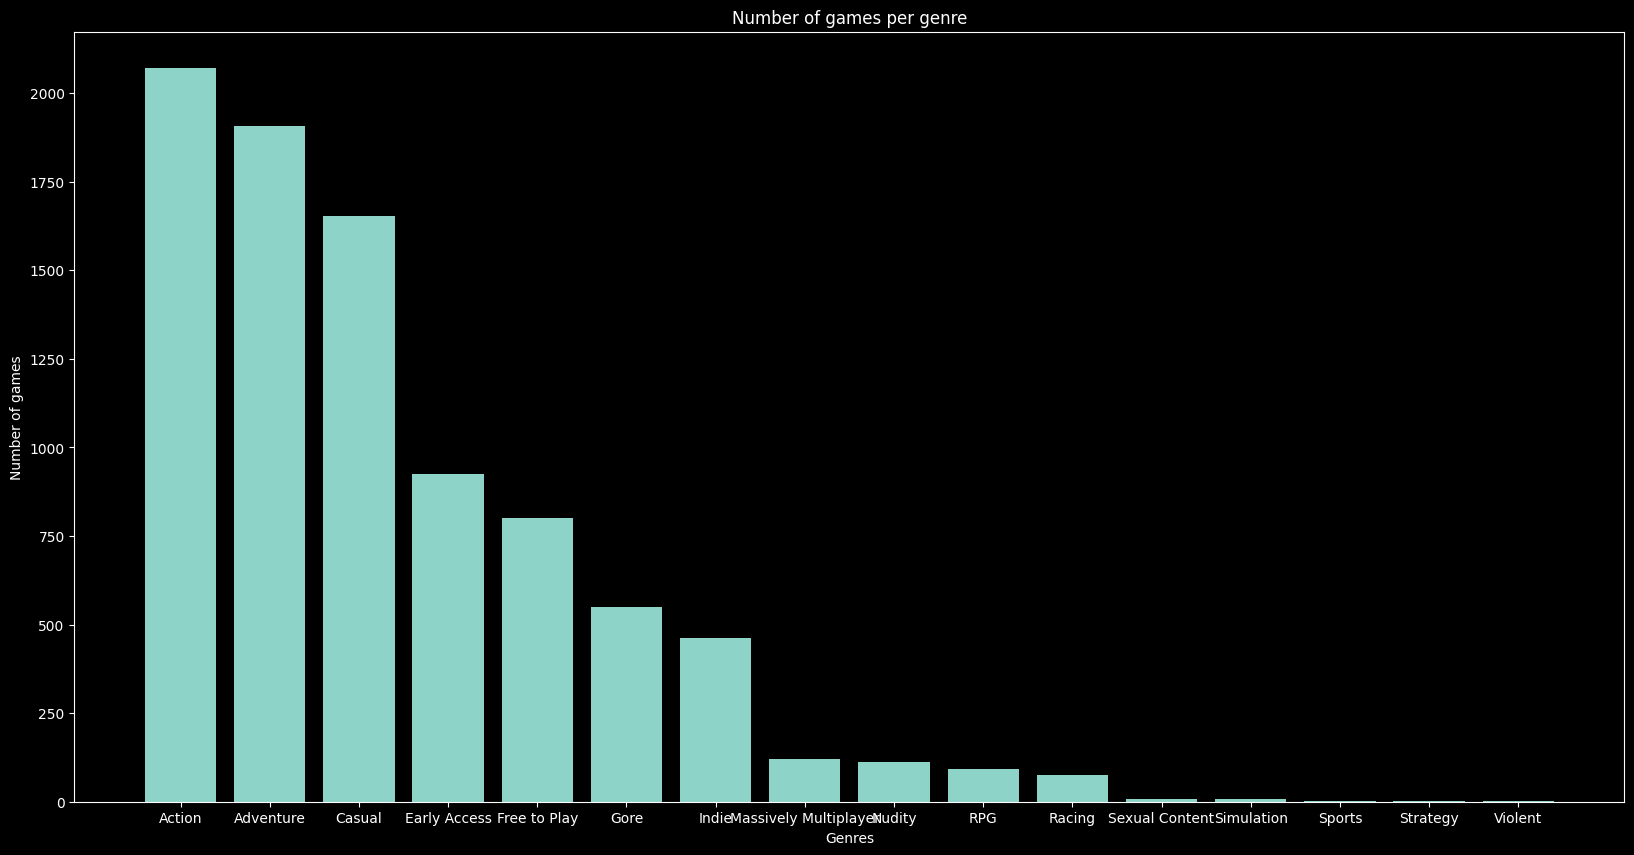

In [140]:
# create a bar graph of the number of games in each genre
# x axis -> genres
# y axis -> number of games
# title -> number of games per genre
# sort from most to least
# and display the graph
# put it in another df as it modify the original df
sortDf = generasDf.copy()
plt.figure(figsize=(20, 10))
# sort from most to least
sortDf.sort(key=lambda x: len(x), reverse=True)
# get the number of games per genre
numGames = [len(x) for x in sortDf]
# get the genres
genres = [x for x in GenresList]
# create a bar graph
plt.bar(genres, numGames)
# add title
plt.title("Number of games per genre")
# add x axis label
plt.xlabel("Genres")
# add y axis label
plt.ylabel("Number of games")
# display the graph
plt.show()


In [141]:
# print top 10 games with highest metacritic score
# sort from highest to lowest

# create a copy of the dataframe
df3 = df2.copy()
# sort from highest to lowest
df3.sort_values(by=['Metacritic score'], inplace=True, ascending=False)
# get the top 10 games with highest metacritic score
top10 = df3.head(10)
# print the top 10 games
print("Top 10 games with highest metacritic score:")
top10

Top 10 games with highest metacritic score:


AppID                                       Name   
45752   632470              Disco Elysium - The Final Cut  \
64935  1687950                            Persona 5 Royal   
32406     7670                                  BioShock™   
57205   271590                         Grand Theft Auto V   
49557       70                                  Half-Life   
36775      220                                Half-Life 2   
28170      620                                   Portal 2   
28484      659                                   Portal 2   
36598   373420  Divinity: Original Sin - Enhanced Edition   
12746     3900               Sid Meier's Civilization® IV   

          Estimated owners                        Genres  Metacritic score  
45752    1000000 - 2000000                           RPG                97  
64935      200000 - 500000                           RPG                97  
32406    2000000 - 5000000                    Action,RPG                96  
57205  20000000 - 50000000              Action,Adventure                96  
49557   5000000 - 10000000                        Action                96  
36775  10000000 - 20000000                        Action                96  
28170  10000000 - 20000000              Action,Adventure                95  
28484            0 - 20000              Action,Adventure                95  
36598    1000000 - 2000000  Adventure,Indie,RPG,Strategy                94  
12746    1000000 - 2000000                      Strategy                94

It look like that those RPG, action and adventure games are dominating the chart -> so it might be that other genres are not as popular as those three genres.

[0.1563287  0.12065231 0.12188553 0.         0.         0.
 0.15176085 0.         0.         0.12685575 0.25285268 0.
 0.20690871 0.27474407 0.1168873  0.        ]
[6.58785233e-12 8.67018405e-07 8.72827972e-03 1.00000000e+00
 1.00000000e+00 1.00000000e+00 3.89973197e-12 1.00000000e+00
 1.00000000e+00 3.16434565e-04 5.13996636e-03 1.00000000e+00
 9.63602179e-07 3.22965243e-03 3.70194601e-04 1.00000000e+00]


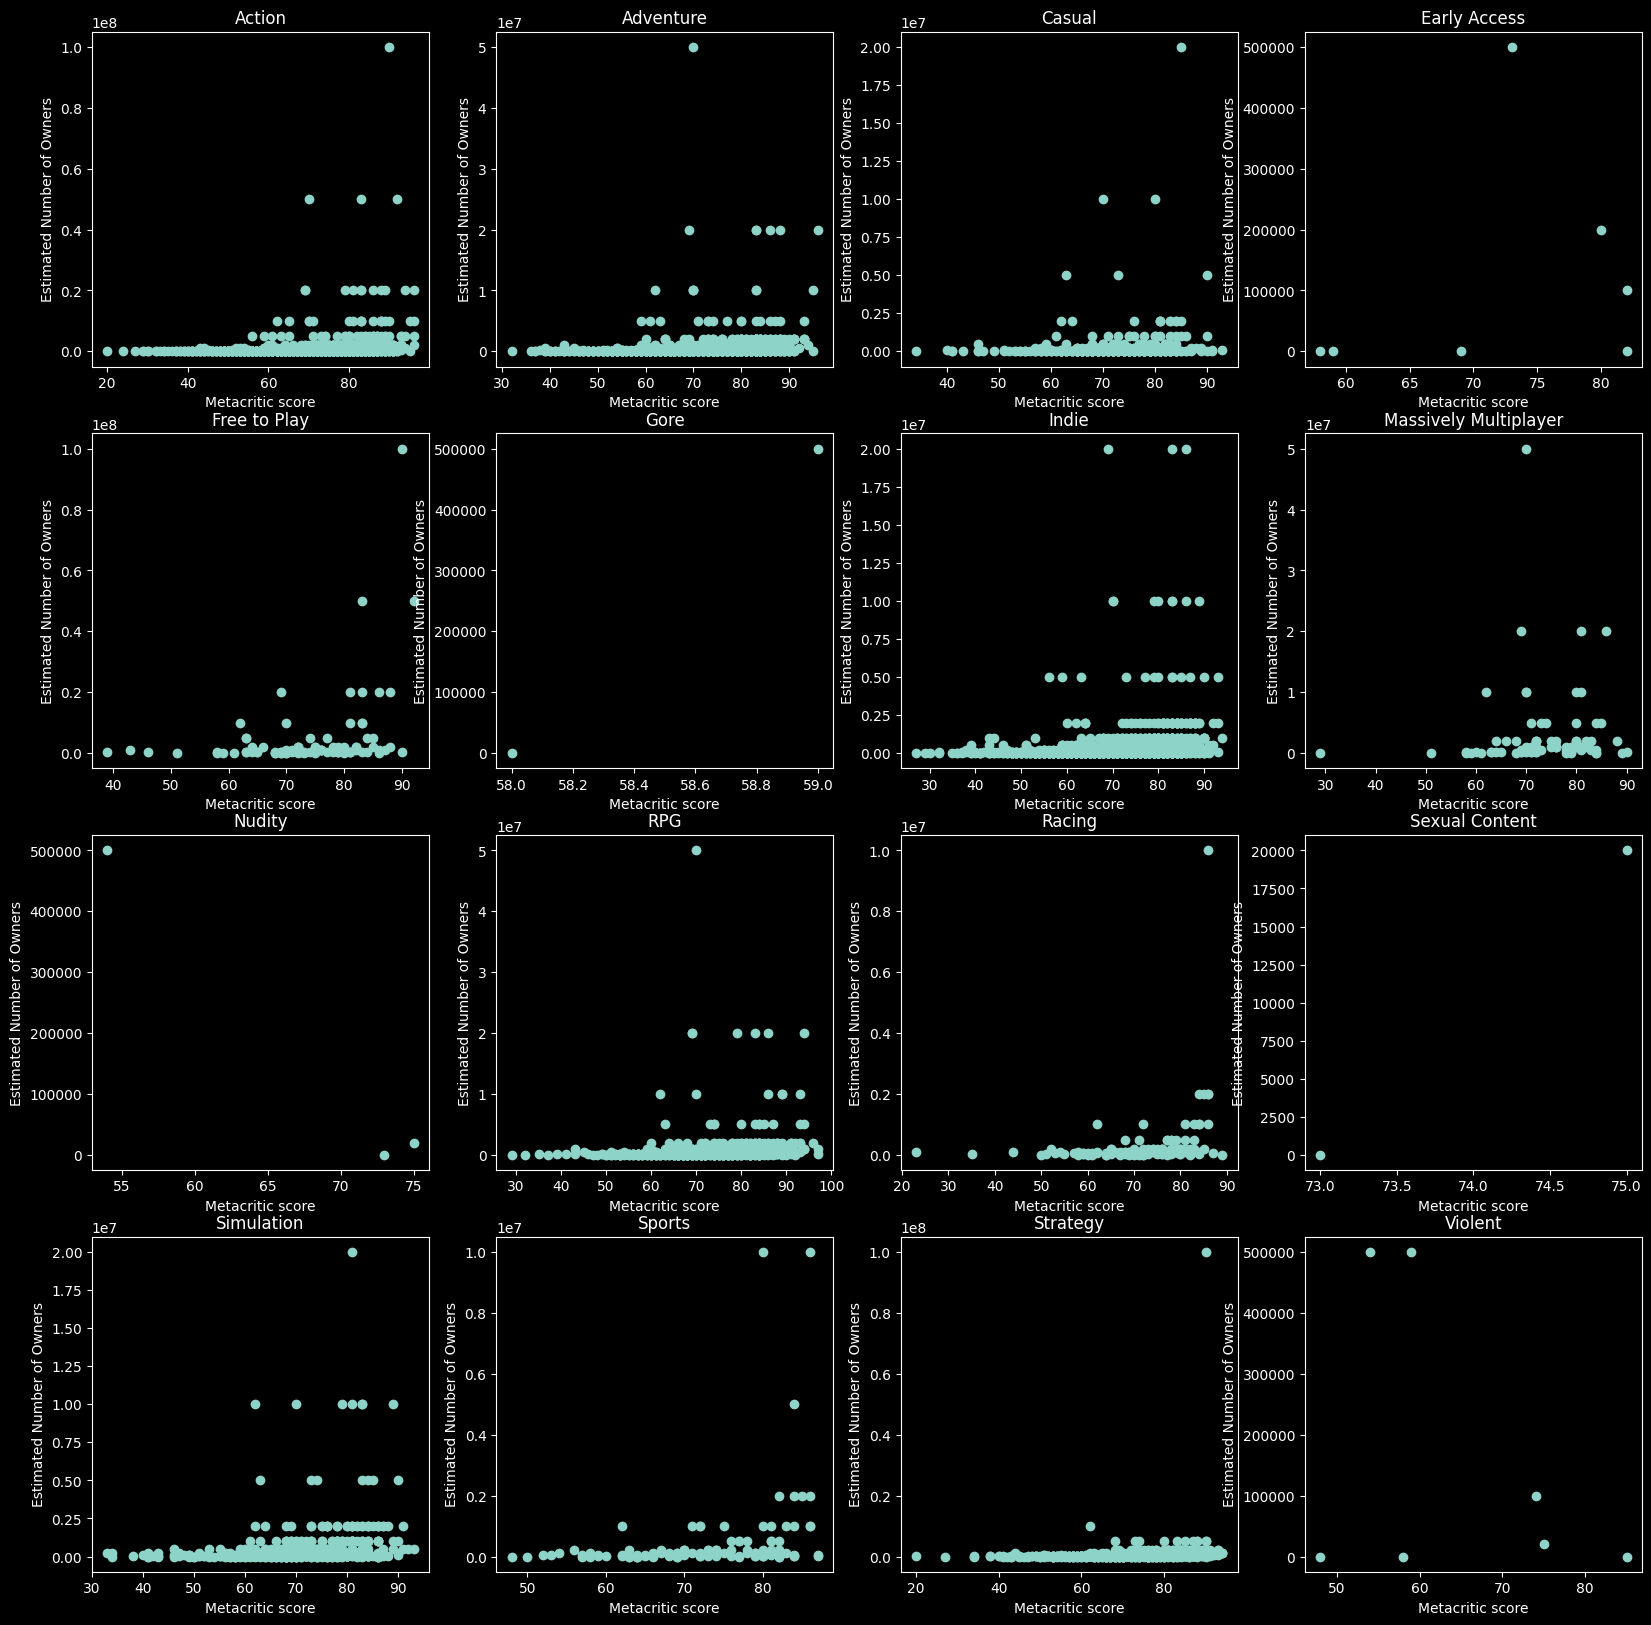

In [142]:
####
# For each genre, plot the metacritic score against the estimated
# number of owners
####

# do stabndard scaler -> scipy
# pairwise plot 
# div into bins -> calc each bins -> bin dependent std 
# rescare y axis 

# Determine the size of the grid
grid_size = math.ceil(math.sqrt(len(generasDf)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# create a scatter plot with the metacritic score on the x
# axis and the number of downloads on the y axis
correlations = []
p_values = []
genreX = np.array([])
genreY = np.array([])

for index, genre in enumerate(generasDf):
  # convert the Metacritic score column to a numpy arary
  x = []
  scores = genre[['Metacritic score']].values
  for score in scores:
    x = np.append(x, score[0])
  genreX = np.append(genreX, x)
  # convert the estimated owners column to a numpy array
  y = []
  ownerRanges = genre[['Estimated owners']].values
  for ownerRange in ownerRanges:
    y = np.append(y, int(re.search(r'\d+', ownerRange[0]).group()))
  genreY = np.append(genreY, y)

  # Use axs[index] instead of plt to plot on the correct subplot
  axs[index].scatter(x, y)
  axs[index].set_title(GenresList[index])
  axs[index].set_xlabel("Metacritic score")
  axs[index].set_ylabel("Estimated Number of Owners")

  # save the correlation coefficient
  # if the number of data points is less than 100, discard the genre
  if (x.shape[0] > 100):
    correlations = np.append(correlations, np.corrcoef(x, y)[0,1])
    p_values = np.append(p_values, stats.pearsonr(x, y)[1])
  else:
    correlations = np.append(correlations, 0)
    p_values = np.append(p_values, 1)

FinalGenres = []
FinalCorrelations = []
FinalPValues = []

# remove all correlations and genres of 0
for index, correlation in enumerate(correlations):
  if (correlation != 0):
    FinalGenres.append(GenresList[index])
    FinalCorrelations.append(correlations[index])
    FinalPValues.append(p_values[index])

if (debug):
  print(correlations)
  print(p_values)

- Action: The Action genre scatter plot does not show a strong correlation between Metacritic scores and the number of owners. There is a wide range of ownership regardless of the scores -> other factors may influence the popularity of action games.

- Adventure: Similar to Action, the Adventure category shows a spread of ownership numbers across various Metacritic scores. It appears that there are a few adventure games with high ownership, regardless of the score.

- Casual: The Casual genre has many games clustered at the lower end of ownership, which may suggest that while there are many casual games available, only a few achieve high ownership.

- Early Access: This category is interesting because it shows a number of games with varying ownership levels despite having lower Metacritic scores. This could indicate that players are interested in engaging with games in development, supporting them before they are fully polished.

- Indie: There's a significant number of indie games with a wide range of scores but generally low ownership. This could be due to the high volume of indie games released, making it harder for individual titles to stand out.

- Massively Multiplayer: There are games with very high ownership numbers in this category, which is not surprising given the social and ongoing nature of MMOs. Critical scores seem less relevant to ownership here, possibly due to community and social aspects of these games.

- Free to Play: This plot shows a large number of owners across all score ranges -> that the free price point is a strong factor in attracting players, regardless of critical reception.

- Gore: Games featuring gore show a smaller spread in ownership and Metacritic scores. The audience for such content may be more niche, resulting in generally lower ownership figures.

- Nudity: A similar pattern to Gore, with an even smaller spread suggesting a niche market. The number of owners tends to be lower compared to other genres.

- RPG: Role-Playing Games have a moderate spread in ownership, with no clear correlation to Metacritic scores. RPGs often have dedicated fan bases that may not be influenced by critical scores.

- Racing: This category does not show a strong correlation between the scores and ownership. The data points are spread out, indicating that racing games can be popular regardless of critical reception.

- Sexual Content: Games with sexual content appear to have a limited audience, as indicated by the generally lower ownership numbers. This niche appeal does not seem to correlate with Metacritic scores.
S
- imulation: Simulation games show a moderate number of owners across a wide range of scores, suggesting that the genre has a steady but not explosive appeal.

- Sports: The Sports genre scatter plot shows a variety of ownership levels with no strong correlation to Metacritic scores. It appears that certain sports titles have a high number of owners, which could be driven by brand loyalty and annual releases.

- Strategy: Strategy games seem to attract a moderate number of owners regardless of Metacritic scores, indicating that fans of the genre may value gameplay mechanics over critical reception.

- Violent: Games labeled as violent are spread across the ownership spectrum, with many games clustered at the lower end of the scale. This suggests that while there is an audience for violent games, it may not be as large as other genres.

In [143]:
# create a DataFrame with the final results
calcDf = pd.DataFrame({'Genre': GenresList, 'Correlation': correlations, 'P-Value': p_values})
calcDf.sort_values(by=['Correlation'], inplace=True, ascending=False)

calcDf



Genre  Correlation       P-Value
13                 Sports     0.274744  3.229652e-03
10                 Racing     0.252853  5.139966e-03
12             Simulation     0.206909  9.636022e-07
0                  Action     0.156329  6.587852e-12
6                   Indie     0.151761  3.899732e-12
9                     RPG     0.126856  3.164346e-04
2                  Casual     0.121886  8.728280e-03
1               Adventure     0.120652  8.670184e-07
14               Strategy     0.116887  3.701946e-04
3            Early Access     0.000000  1.000000e+00
4            Free to Play     0.000000  1.000000e+00
5                    Gore     0.000000  1.000000e+00
7   Massively Multiplayer     0.000000  1.000000e+00
8                  Nudity     0.000000  1.000000e+00
11         Sexual Content     0.000000  1.000000e+00
15                Violent     0.000000  1.000000e+00

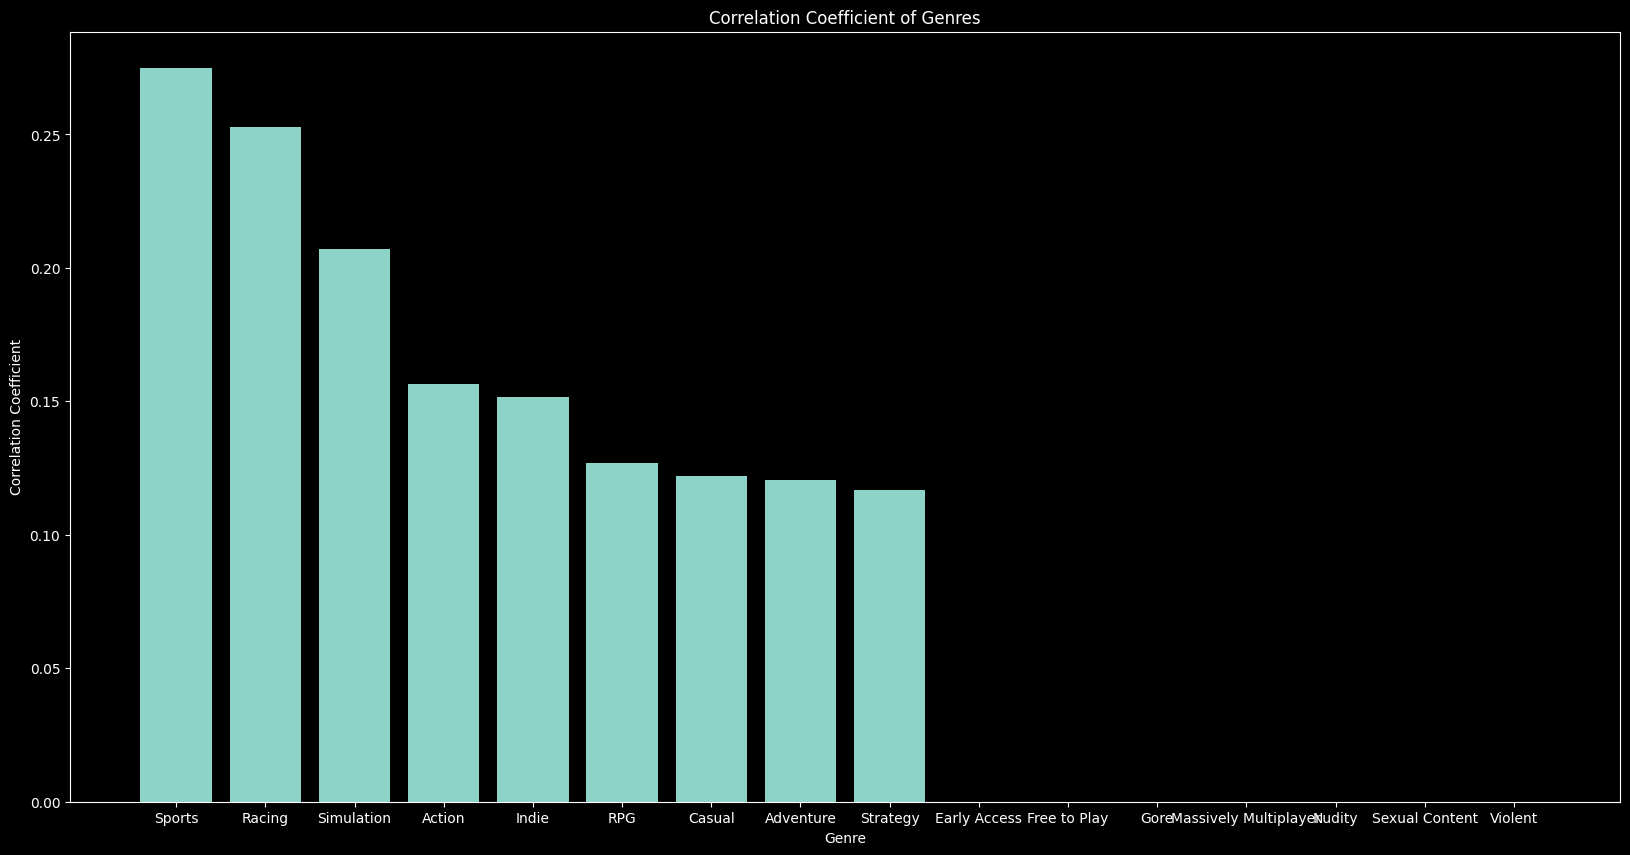

In [144]:
# bar graph of correlation coefficient
plt.figure(figsize=(20, 10))
plt.bar(calcDf['Genre'], calcDf['Correlation'])
plt.title("Correlation Coefficient of Genres")
plt.xlabel("Genre")
plt.ylabel("Correlation Coefficient")
plt.show()


Before we normalize -> sport is the one that metacritic score matter the most 

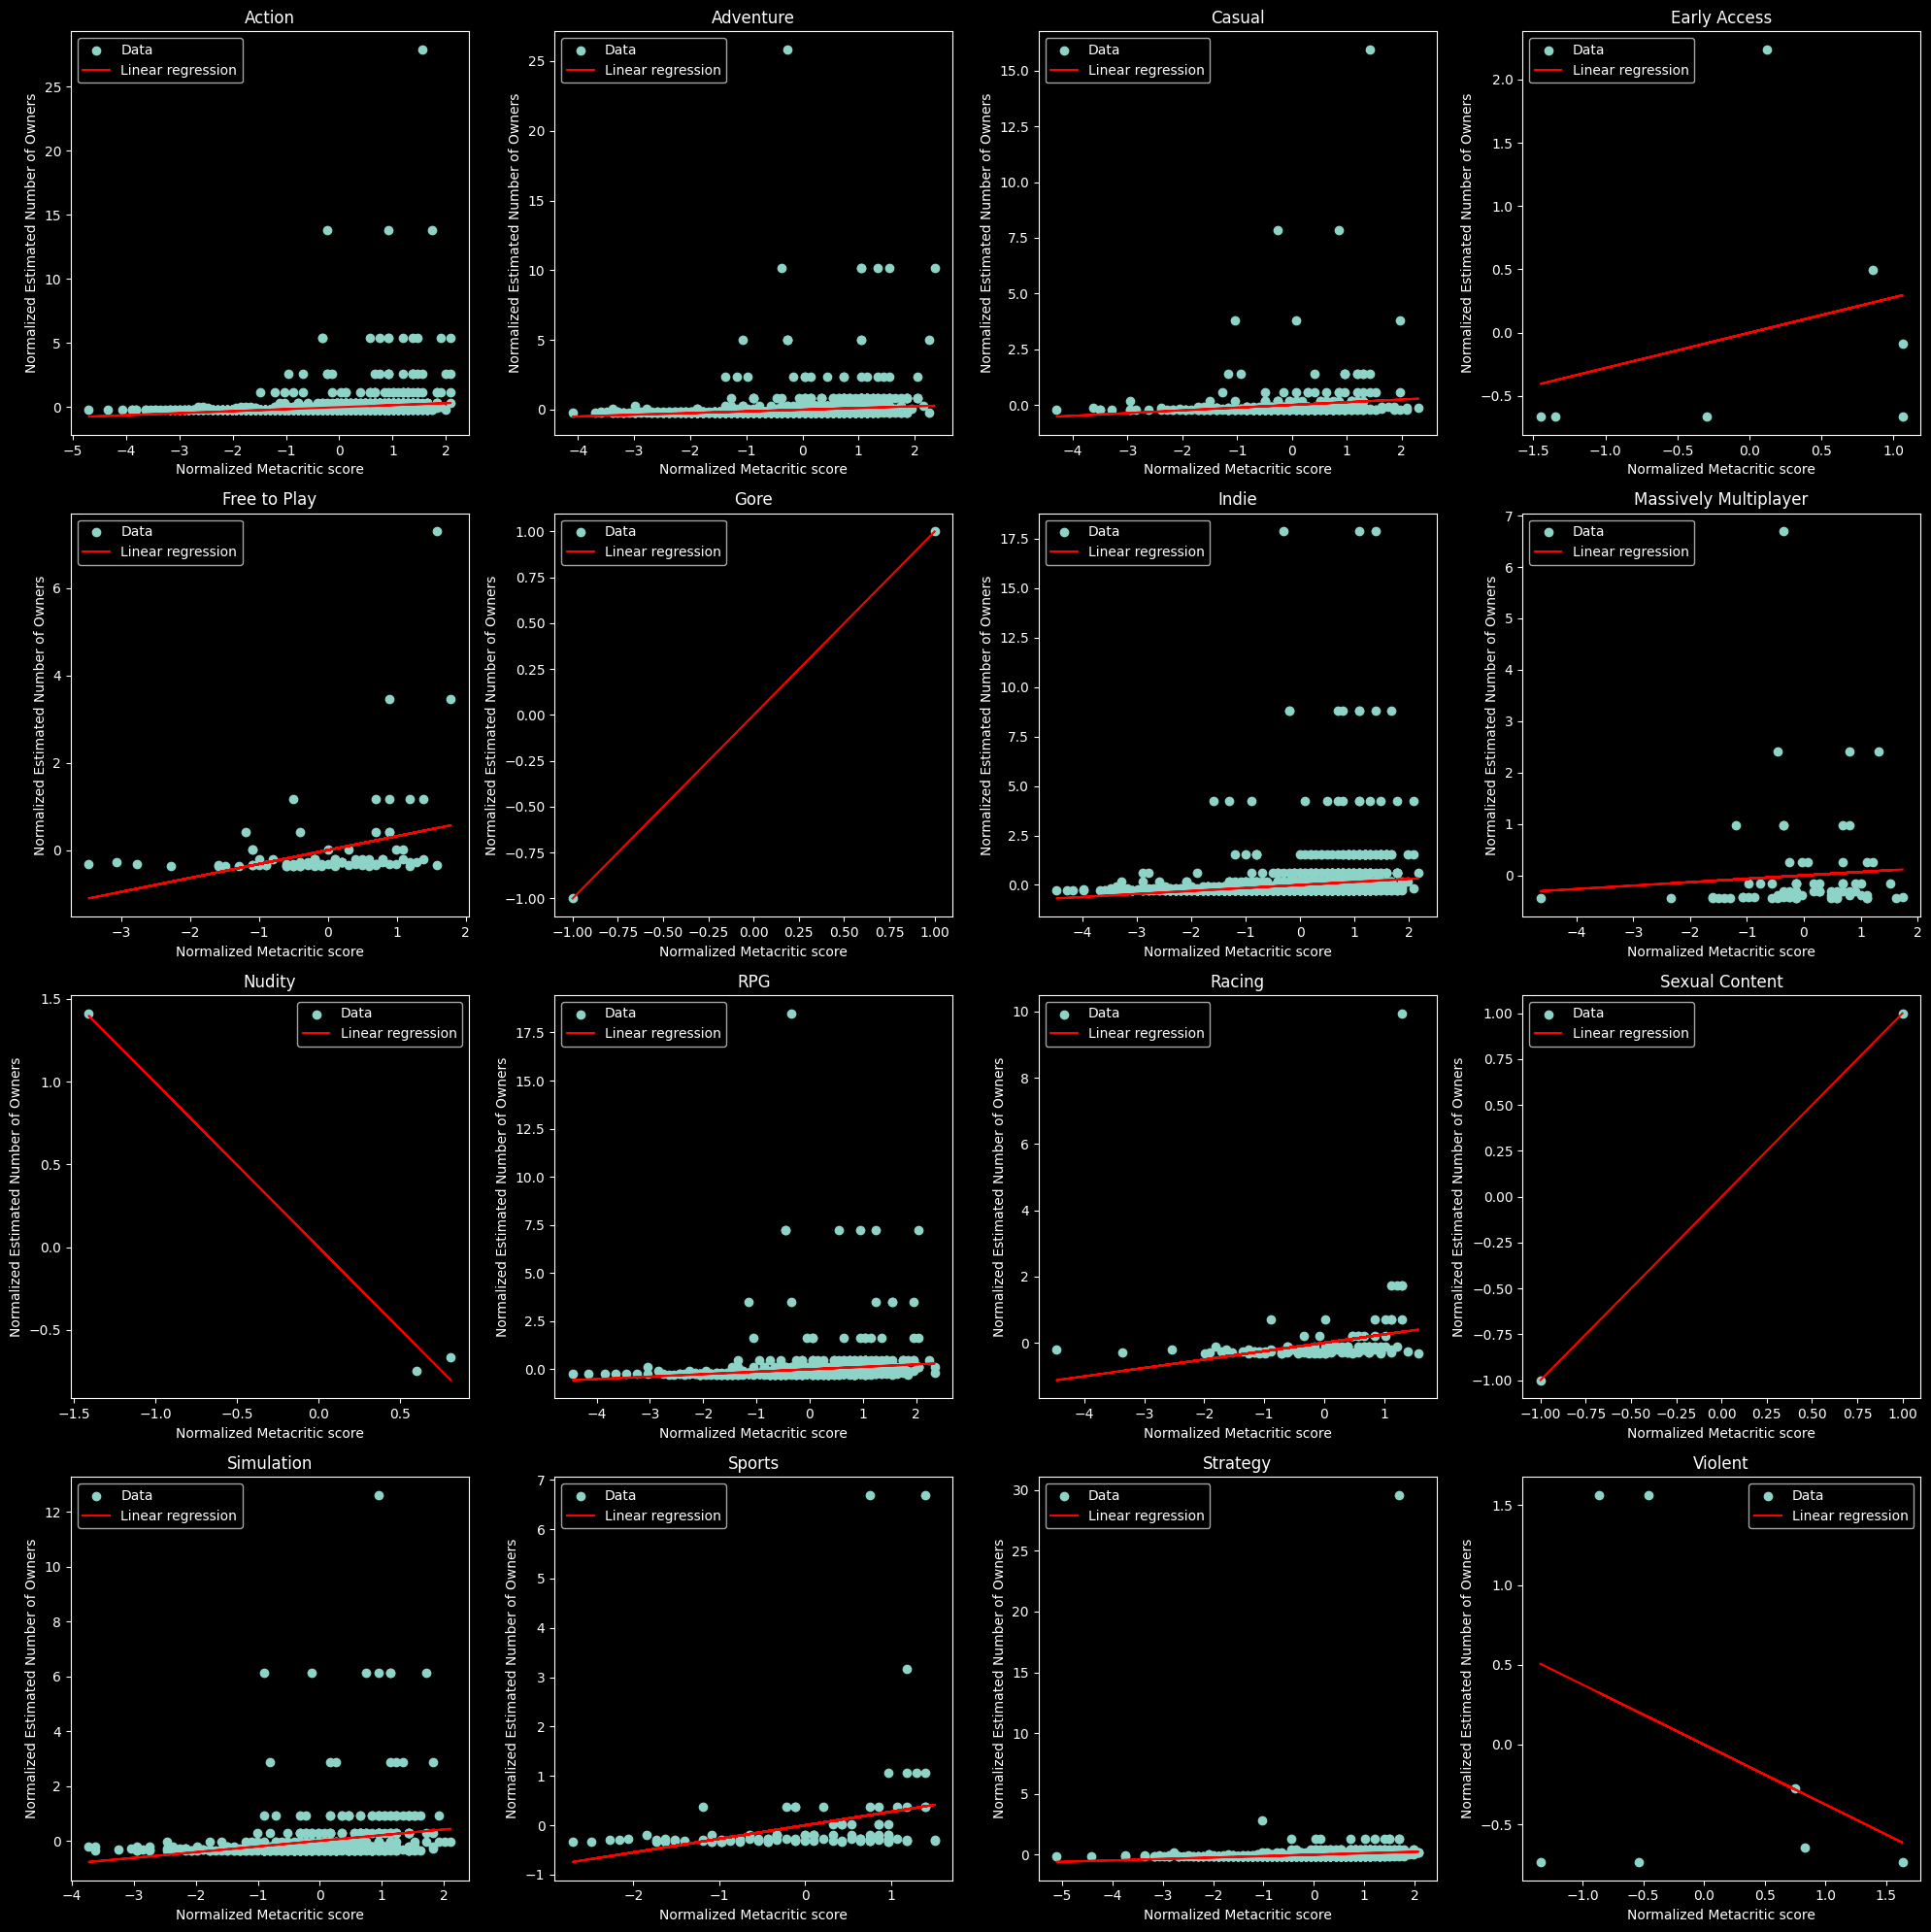

<Figure size 640x480 with 0 Axes>

In [145]:
# attempt to try to nornalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# prof recommendation: use standard scaler or use bins and calcualte the std of each bin and rescale the y axis 
# we also can do pairwise plot to see the correlation between each pair of genres

correlations = []
p_values = []

grid_size = math.ceil(math.sqrt(len(generasDf)))  # Determine the size of the grid

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))  # Create the grid
axs = axs.flatten()  # Flatten the axes array for easy iteration

for index, genre in enumerate(generasDf):  # For each genre
    x = genre['Metacritic score'].values  # Get the Metacritic score values
    y = genre['Estimated owners'].apply(lambda x: int(re.search(r'\d+', x).group())).values  # Get the estimated owners values

    # Initialize the scaler and normalize the data for each genre
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x.reshape(-1, 1)).flatten()  # Normalize Metacritic scores
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normalize ownership numbers

    # Linear regression
    model = LinearRegression().fit(x_scaled.reshape(-1, 1), y_scaled)  # Fit model
    y_pred = model.predict(x_scaled.reshape(-1, 1))  # Predict y values

    axs[index].scatter(x_scaled, y_scaled, label='Data')  # Plot the normalized data
    axs[index].plot(x_scaled, y_pred, color='red', label='Linear regression')  # Plot the linear regression
    axs[index].set_title(GenresList[index])  # Set the title for each subplot
    axs[index].set_xlabel("Normalized Metacritic score")  # Set the x-axis label
    axs[index].set_ylabel("Normalized Estimated Number of Owners")  # Set the y-axis label
    axs[index].legend()  # Add a legend to each subplot

    corr, p_val = stats.pearsonr(x_scaled, y_scaled)  # Calculate the correlation coefficient and p-value
    correlations.append(corr)  # Append the correlation coefficient to the list
    p_values.append(p_val)  # Append the p-value to the list

plt.tight_layout()  # Adjust the layout
plt.show()  # Show the plot

FinalGenres = []
FinalCorrelations = []
FinalPValues = []

# remove all correlations and genres of 0
for index, correlation in enumerate(correlations):
  if (correlation != 0):
    FinalGenres.append(GenresList[index])
    FinalCorrelations.append(correlations[index])
    FinalPValues.append(p_values[index])

plt.tight_layout() # Adjust the layout
plt.show() # Show the plot



- Action: The regression line is relatively flat, indicating a weak or no correlation between Metacritic scores and the game's popularity within the Action genre.

- Adventure: The Adventure genre also shows a flat regression line, suggesting no significant relationship between the scores and how many people own the games.

- Casual: This genre has a slightly positive slope in the regression line, which might suggest a small positive correlation between higher Metacritic scores and popularity.

- Early Access: The positive slope is more pronounced here, indicating that for Early Access games, there could be a moderate positive correlation between higher scores and greater popularity.

- Free to Play: The regression line shows a slight positive trend, suggesting that better-reviewed Free to Play games might have a slightly higher number of owners.

- Gore: The regression line for Gore games has a steep positive slope, indicating a strong positive correlation between higher scores and more owners - higher quality as perceived by critics aligns with more popularity.

- Indie: This category has a flat regression line, meaning there is no clear correlation between the scores and the number of owners.

- Massively Multiplayer: The regression line trends upwards slightly, suggesting a small positive correlation between higher scores and popularity.

- Nudity: The steep negative slope of the regression line indicates a strong negative correlation; as Metacritic scores increase, the popularity of games with Nudity content seems to decrease.

- RPG: The regression line is flat, showing no clear correlation between scores and popularity within the Role-Playing Game genre.

- Racing: Similar to RPGs, the Racing genre shows a flat regression line, suggesting no strong correlation between Metacritic scores and game popularity.

- Sexual Content: The positive slope of the regression line indicates a moderate correlation; games with Sexual Content that have higher scores tend to be more popular.

- Simulation: The regression line for Simulation games has a slight negative slope, which may suggest a weak negative correlation between scores and popularity.

- Sports: The regression line is relatively flat, indicating no significant correlation between scores and the popularity of Sports games.

- Strategy: The regression line for Strategy games is flat, indicating that there's no clear correlation between the Metacritic scores and the number of owners.

- Violent: There is a steep negative slope in the regression line, indicating a strong negative correlation; as the Metacritic scores for Violent games increase, the popularity appears to decrease.

In [146]:
# create a DataFrame with the final results
calcDf = pd.DataFrame({'Genre': FinalGenres, 'Correlation': FinalCorrelations, 'P-Value': FinalPValues})
calcDf.sort_values(by=['Correlation'], inplace=True, ascending=False)

calcDf



Genre  Correlation       P-Value
5                    Gore     1.000000  1.000000e+00
11         Sexual Content     1.000000  1.000000e+00
4            Free to Play     0.318506  1.973194e-03
3            Early Access     0.278455  5.453915e-01
13                 Sports     0.274744  3.229652e-03
10                 Racing     0.252853  5.139966e-03
12             Simulation     0.206909  9.636022e-07
0                  Action     0.156329  6.587852e-12
6                   Indie     0.151761  3.899732e-12
9                     RPG     0.126856  3.164346e-04
2                  Casual     0.121886  8.728280e-03
1               Adventure     0.120652  8.670184e-07
14               Strategy     0.116887  3.701946e-04
7   Massively Multiplayer     0.066118  5.730245e-01
15                Violent    -0.375143  4.069879e-01
8                  Nudity    -0.992601  7.748953e-02

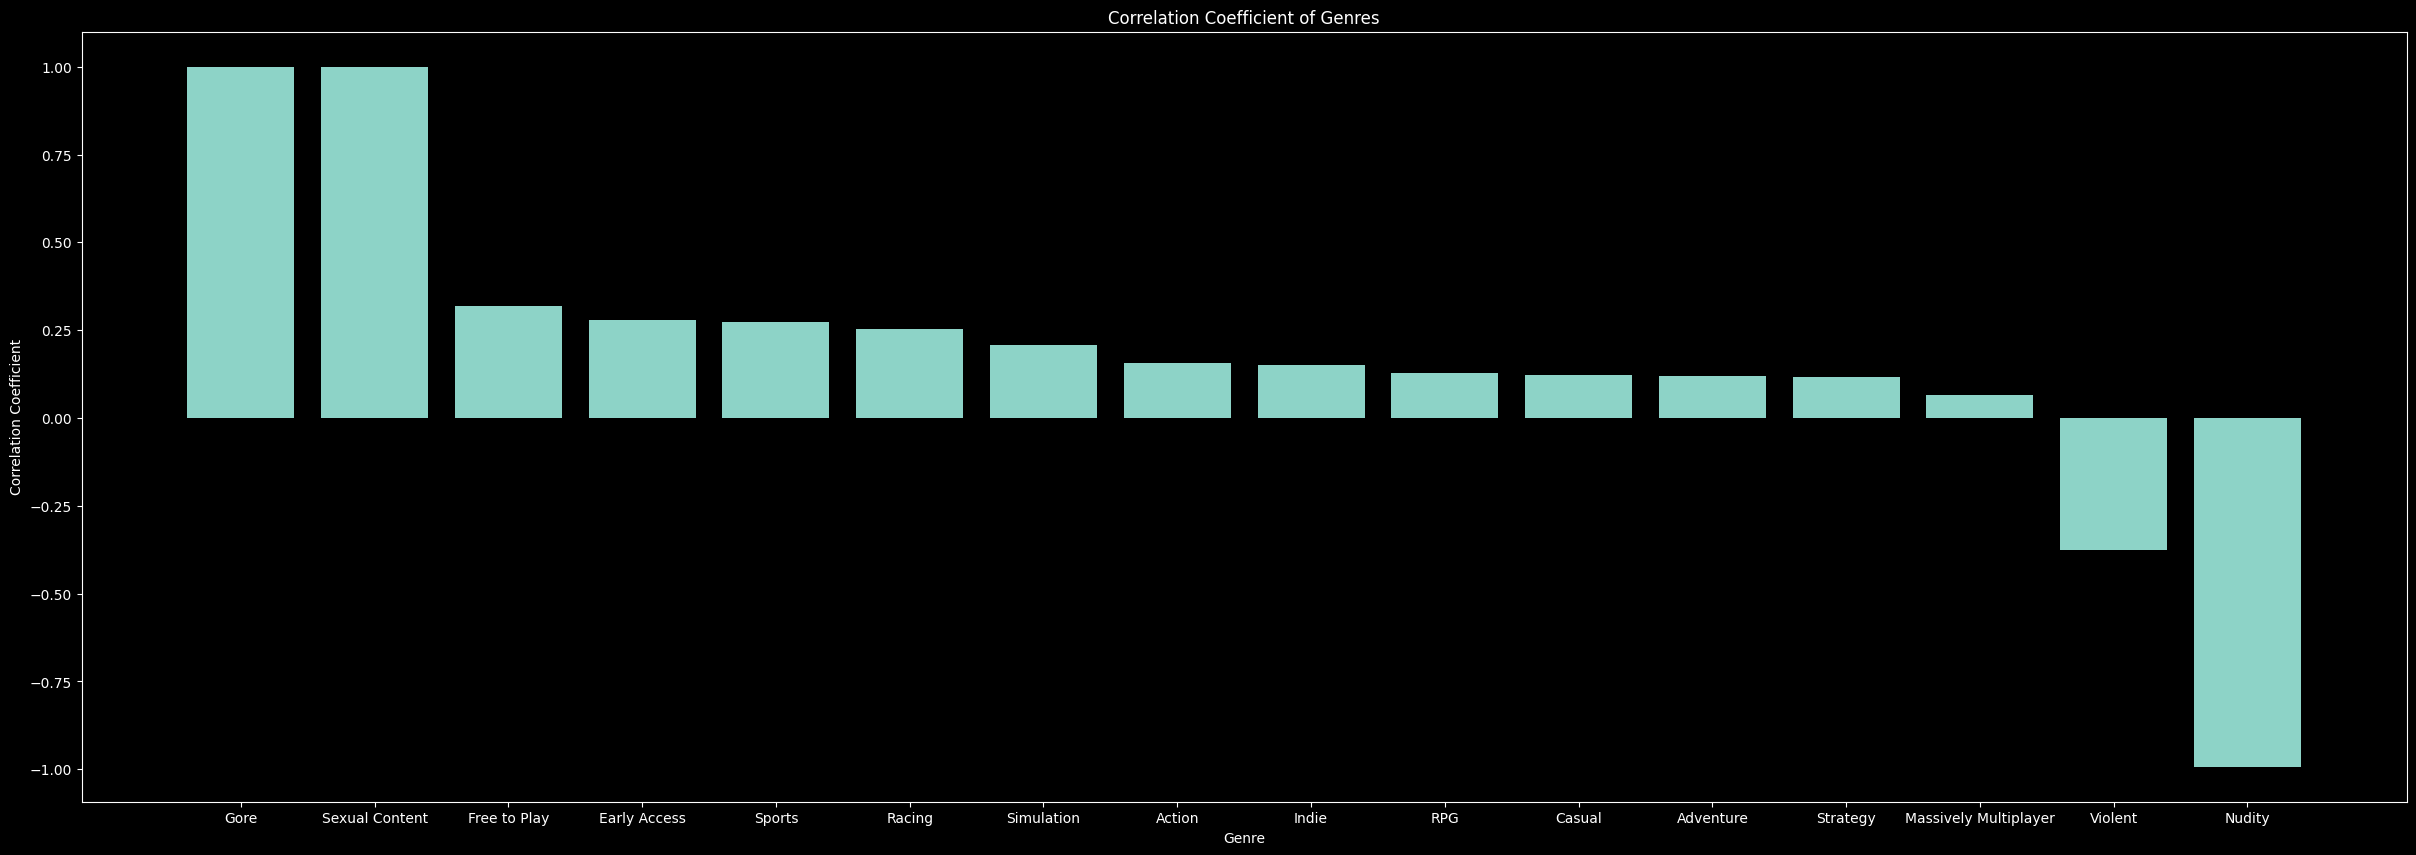

In [147]:
# bar graph of correlation coefficient
plt.figure(figsize=(30, 10))
plt.bar(calcDf['Genre'], calcDf['Correlation'])
plt.title("Correlation Coefficient of Genres")
plt.xlabel("Genre")
plt.ylabel("Correlation Coefficient")
plt.show()


After normalize -> gore and sexual content are the one that metacritic score matter the most -> but bc it only has 2 games 
so we will remove it and only use top 3 genres: free to play, early access and sport

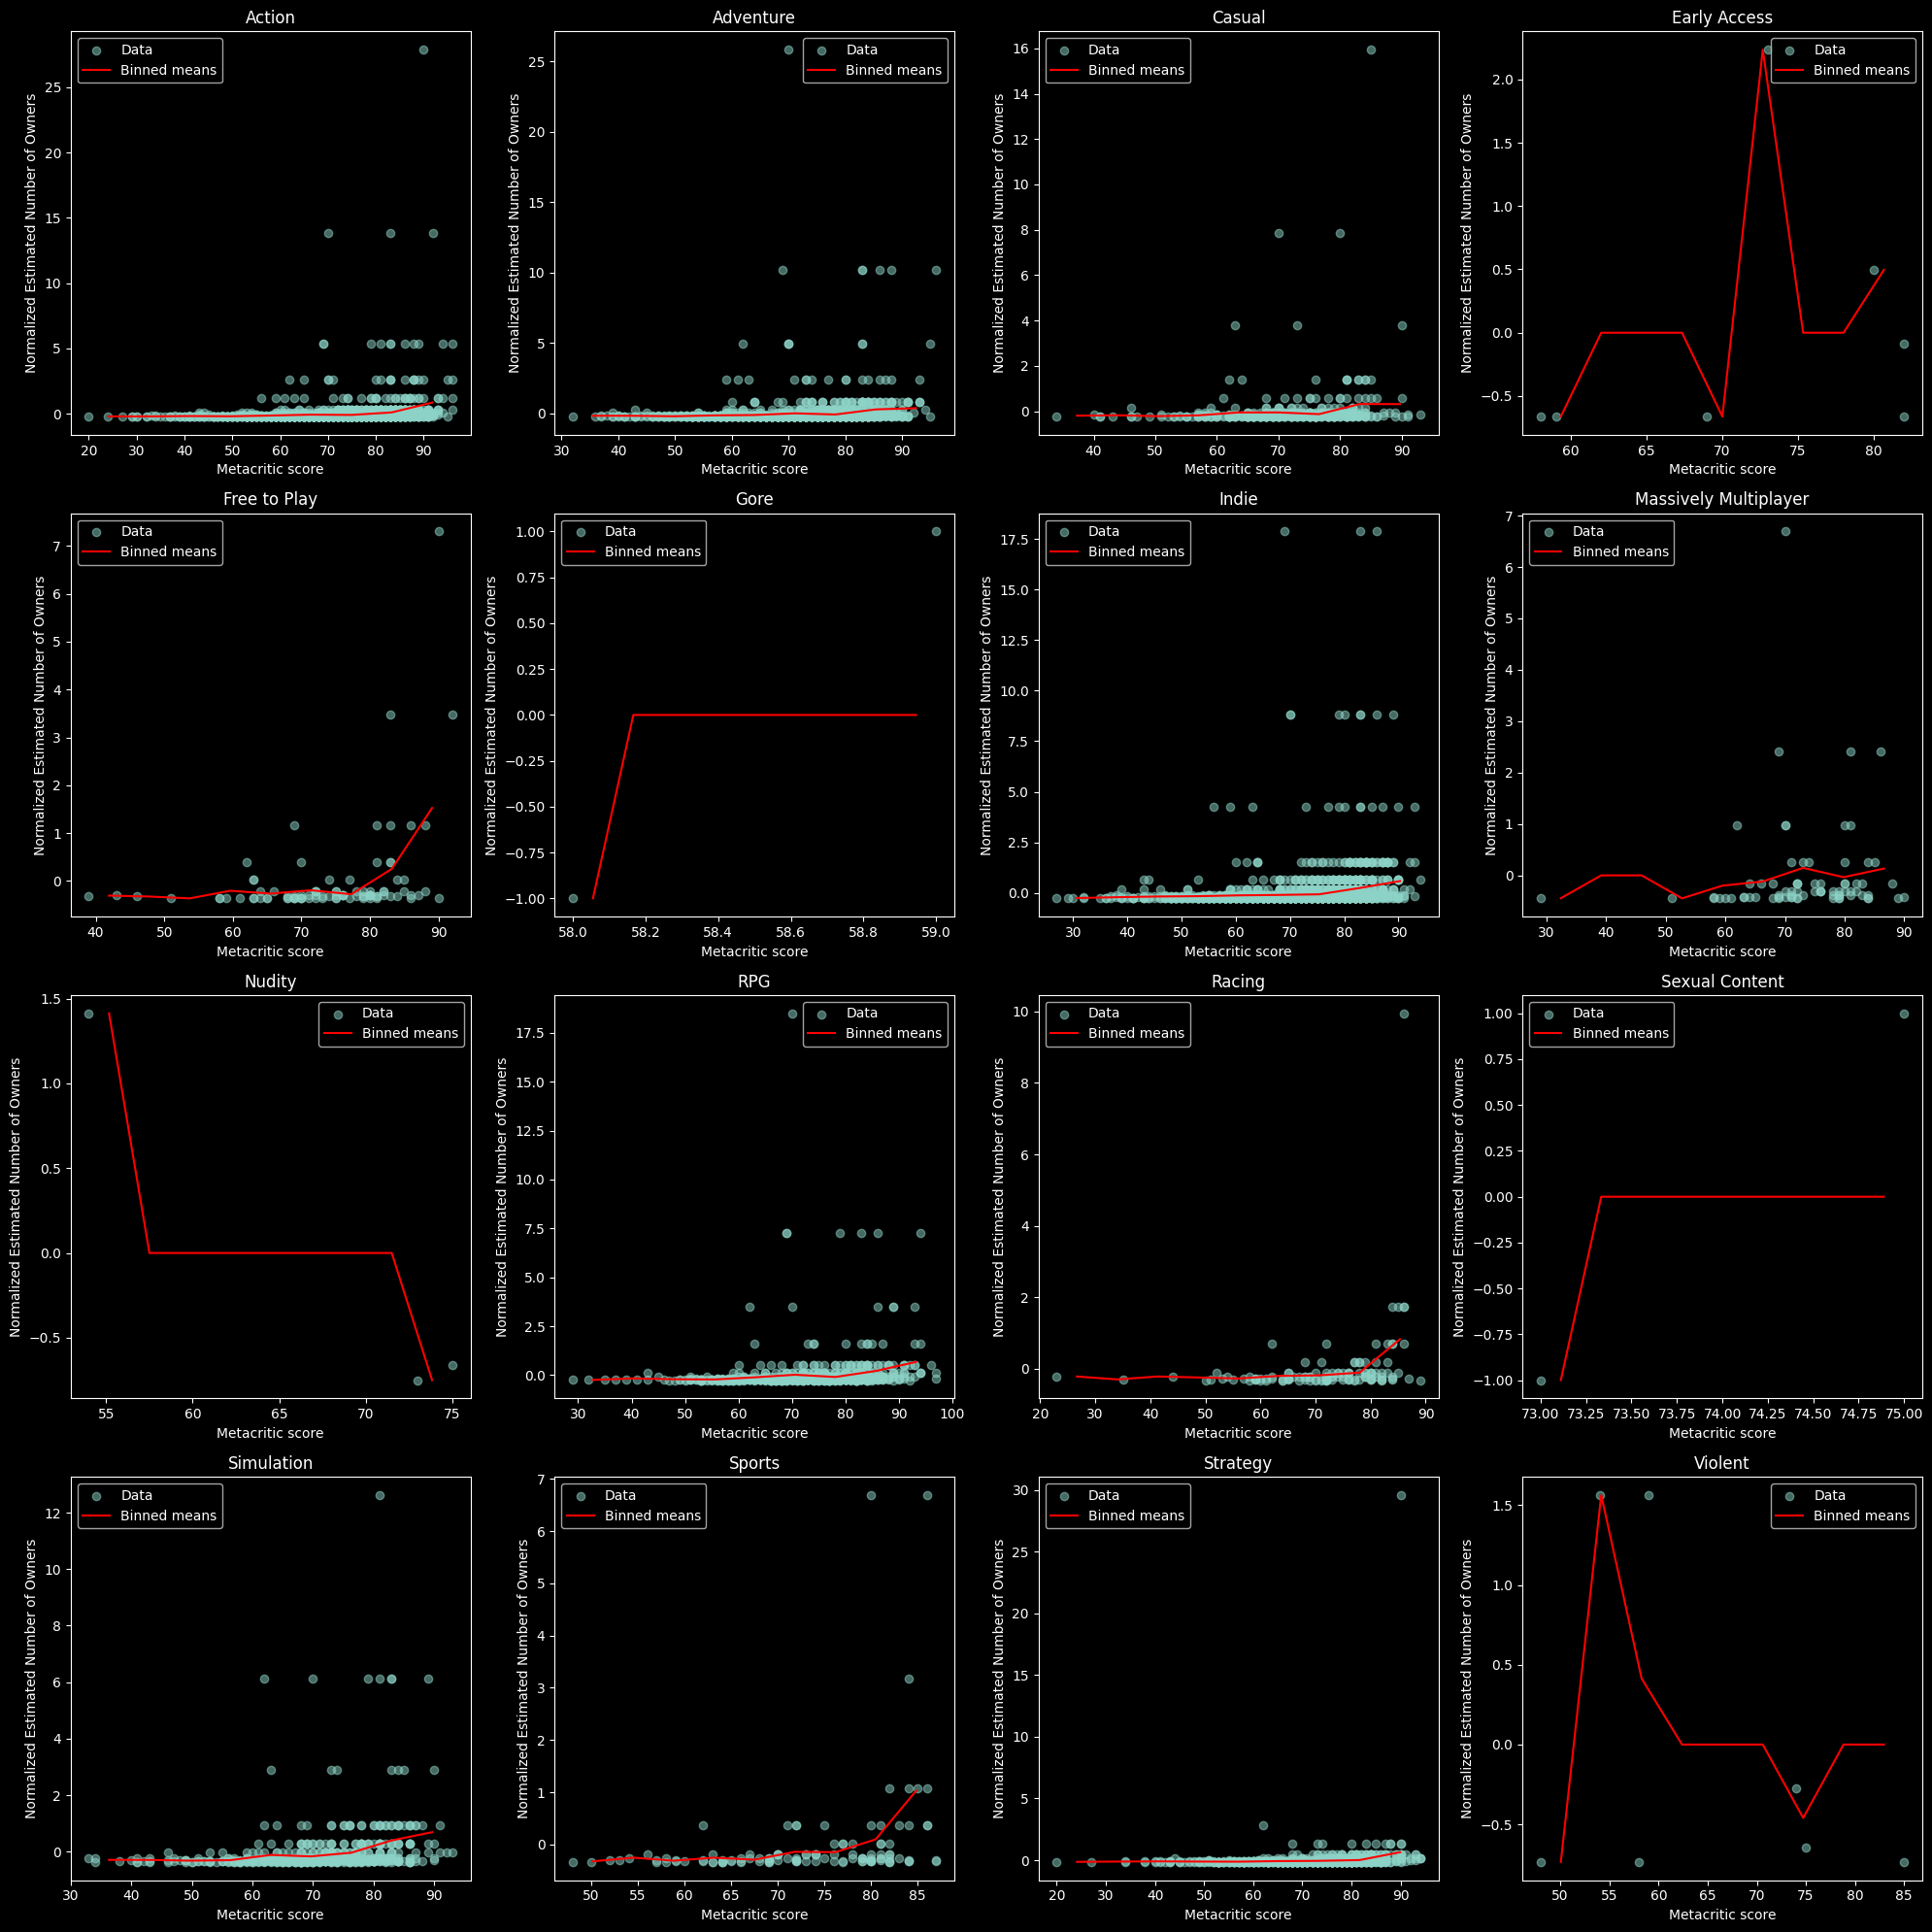

In [148]:
# bin method 
correlations = []
p_values = []

grid_size = math.ceil(math.sqrt(len(generasDf)))  # Determine the size of the grid

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))  # Create the grid
axs = axs.flatten()  # Flatten the axes array for easy iteration

for index, genre in enumerate(generasDf):  # For each genre
    x = genre['Metacritic score'].values  # Get the Metacritic score values
    y = genre['Estimated owners'].apply(lambda x: int(re.search(r'\d+', x).group())).values  # Get the estimated owners values

    # Normalize the y-values within each genre
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normalize ownership numbers

    # Define the number of bins
    num_bins = 10
    bins = np.linspace(np.min(x), np.max(x), num_bins)
    inds = np.digitize(x, bins)

    # Bin the data using normalized y-values
    binned_means = [y_scaled[inds == i].mean() if not np.isnan(y_scaled[inds == i]).all() else 0 for i in range(1, len(bins))]

    # Plot the binned data
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    axs[index].scatter(x, y_scaled, label='Data', alpha=0.5)
    axs[index].plot(bin_centers, binned_means, color='red', label='Binned means', zorder=5)

    # Calculate the correlation using normalized y-values
    corr, p_val = stats.pearsonr(x, y_scaled)
    correlations.append(corr)
    p_values.append(p_val)

    # Set plot titles and labels
    axs[index].set_title(GenresList[index])
    axs[index].set_xlabel("Metacritic score")
    axs[index].set_ylabel("Normalized Estimated Number of Owners")
    axs[index].legend()

FinalGenres = []
FinalCorrelations = []
FinalPValues = []

# remove all correlations and genres of 0
for index, correlation in enumerate(correlations):
  if (correlation != 0):
    FinalGenres.append(GenresList[index])
    FinalCorrelations.append(correlations[index])
    FinalPValues.append(p_values[index])

plt.tight_layout()
plt.show()


- Action: The binned means show some fluctuation, but there's a noticeable dip in the mid-range of Metacritic scores, suggesting that games in the mid-range do not necessarily have higher popularity.

- Adventure: This genre shows a gentle fluctuation with no clear trend in the binned means, indicating no strong relationship between Metacritic scores and game popularity.

- Casual: The binned means for Casual games show very little variation, indicating that Metacritic scores have little impact on the popularity of games in this category.

- Early Access: There's a significant spike in the binned means for one of the score ranges. This suggests a specific subset of Early Access games with those scores is particularly popular.

- Free to Play: The binned means for Free to Play games shows an increase as the Metacritic score increases, suggesting a positive relationship between game quality (as perceived by critics) and popularity.

- Gore: The binned means line is relatively flat, indicating that the popularity of games featuring gore is not strongly related to their Metacritic scores.

- Indie: The binned means line is erratic with no clear trend, suggesting that for Indie games, Metacritic scores do not have a predictable impact on popularity.

- Massively Multiplayer: This category has a slight upward trend in the binned means, indicating a potential positive relationship between scores and popularity.

- Nudity: The binned means line drops sharply at first and then levels off, indicating that games with higher scores are not necessarily more popular in this category.

- RPG: The binned means line for RPGs is relatively flat, suggesting no strong correlation between Metacritic scores and popularity.

- Racing: The binned means are mostly flat with a slight uptick at higher scores, hinting at a weak positive relationship between scores and popularity.

- Sexual Content: The binned means line for Sexual Content is relatively flat, suggesting that the popularity of these games is not strongly influenced by Metacritic scores.

- Simulation: The binned means for Simulation games shows a slight increase with higher scores, suggesting a weak positive relationship between the scores and popularity.

- Sports: The binned means for Sports games show a slight upward trend, indicating a possible positive correlation between scores and game popularity.

- Strategy: The binned means show an increase with higher Metacritic scores, suggesting that higher-rated Strategy games tend to be more popular.

- Violent: There is a significant fluctuation in the binned means for Violent games, with popularity peaking at certain score intervals but not consistently related to the Metacritic scores.

In [149]:
# create a DataFrame with the final results
calcDf = pd.DataFrame({'Genre': FinalGenres, 'Correlation': FinalCorrelations, 'P-Value': FinalPValues})
calcDf.sort_values(by=['Correlation'], inplace=True, ascending=False)

calcDf

Genre  Correlation       P-Value
5                    Gore     1.000000  1.000000e+00
11         Sexual Content     1.000000  1.000000e+00
4            Free to Play     0.318506  1.973194e-03
3            Early Access     0.278455  5.453915e-01
13                 Sports     0.274744  3.229652e-03
10                 Racing     0.252853  5.139966e-03
12             Simulation     0.206909  9.636022e-07
0                  Action     0.156329  6.587852e-12
6                   Indie     0.151761  3.899732e-12
9                     RPG     0.126856  3.164346e-04
2                  Casual     0.121886  8.728280e-03
1               Adventure     0.120652  8.670184e-07
14               Strategy     0.116887  3.701946e-04
7   Massively Multiplayer     0.066118  5.730245e-01
15                Violent    -0.375143  4.069879e-01
8                  Nudity    -0.992601  7.748953e-02

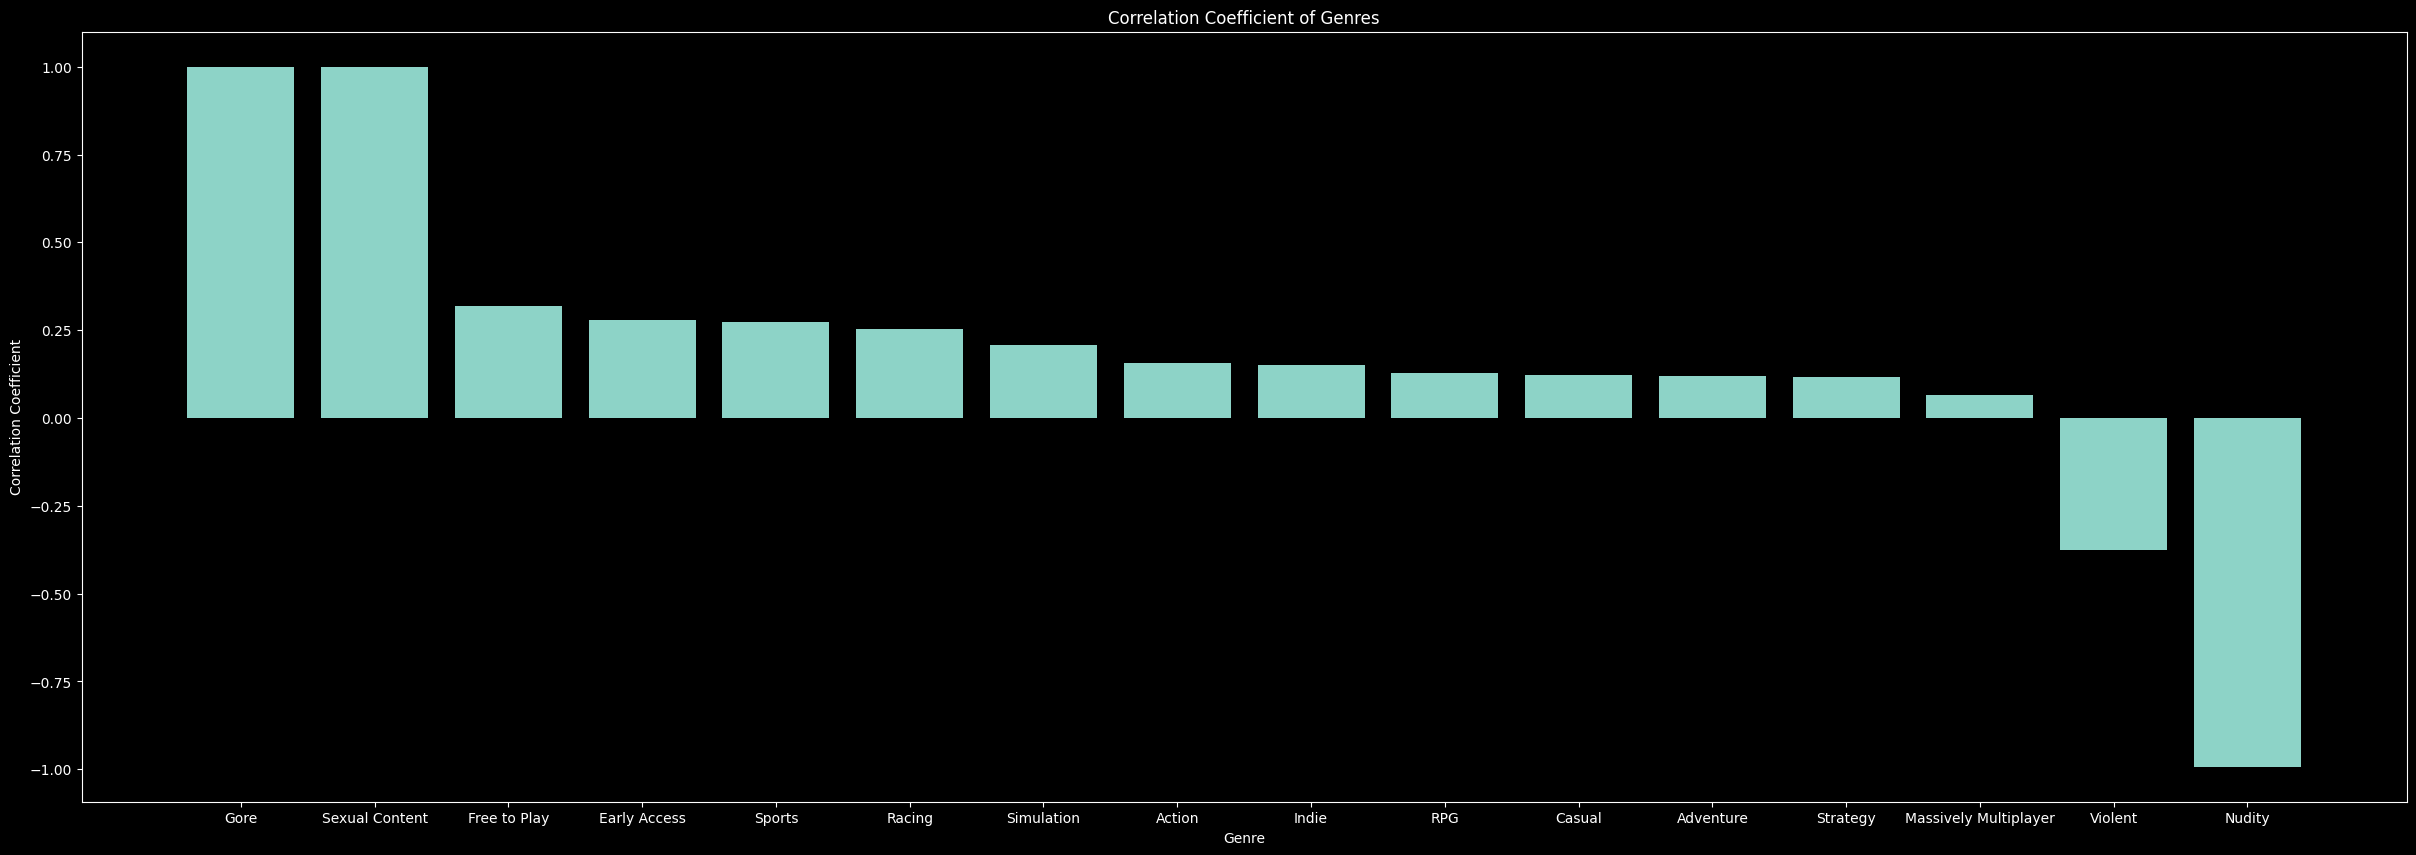

In [150]:
# bar graph of correlation coefficient
plt.figure(figsize=(30, 10))
plt.bar(calcDf['Genre'], calcDf['Correlation'])
plt.title("Correlation Coefficient of Genres")
plt.xlabel("Genre")
plt.ylabel("Correlation Coefficient")
plt.show()

In [151]:
def plot_genre_comparisons(all_genres_data, main_genre, GenresList, num_bins=10):
    main_genre_data = all_genres_data[all_genres_data['Genre'] == main_genre]
    
    fig, axs = plt.subplots(len(GenresList), 2, figsize=(20, (len(GenresList)) * 5))

    for index, genre_name in enumerate(GenresList):
        if genre_name != main_genre:
            genre_data = all_genres_data[all_genres_data['Genre'] == genre_name]
            data = pd.concat([main_genre_data, genre_data])

            # Binned Data Plot
            ax_bin = axs[index, 0]
            plot_binned_data(ax_bin, data, main_genre, num_bins)

            # Linear Regression Plot
            ax_lin = axs[index, 1]
            plot_linear_regression(ax_lin, main_genre_data, genre_data, main_genre, genre_name)
    
    plt.tight_layout()
    plt.show()

def plot_binned_data(ax, data, main_genre, num_bins):
    ax.scatter(data['Normalized Metacritic score'], data['Normalized Estimated Number of Owners'], color='grey', alpha=0.5)
    data['Binned Metacritic score'] = pd.cut(data['Normalized Metacritic score'], bins=num_bins)
    binned_means = data.groupby(['Genre', 'Binned Metacritic score'])['Normalized Estimated Number of Owners'].mean().reset_index()
    for genre in binned_means['Genre'].unique():
        binned_genre_data = binned_means[binned_means['Genre'] == genre]
        binned_x = binned_genre_data['Binned Metacritic score'].apply(lambda x: x.mid).values
        binned_y = binned_genre_data['Normalized Estimated Number of Owners'].values
        color = 'red' if genre == main_genre else 'blue'
        ax.plot(binned_x, binned_y, color=color, label=f'{genre} Binned Mean')
    ax.set_title(f'Binned Data: {main_genre} vs Other Genres')
    ax.set_xlabel('Normalized Metacritic score')
    ax.set_ylabel('Normalized Estimated Number of Owners')
    ax.legend()

def plot_linear_regression(ax, main_genre_data, genre_data, main_genre, genre_name):
    # Main genre linear regression
    model_main = LinearRegression()
    X_main = main_genre_data['Normalized Metacritic score'].values.reshape(-1, 1)
    Y_main = main_genre_data['Normalized Estimated Number of Owners'].values
    model_main.fit(X_main, Y_main)
    trendline_main = model_main.predict(X_main)
    ax.plot(X_main, trendline_main, color='red', label=f'{main_genre} Trend Line')

    # Compared genre linear regression
    model_genre = LinearRegression()
    X_genre = genre_data['Normalized Metacritic score'].values.reshape(-1, 1)
    Y_genre = genre_data['Normalized Estimated Number of Owners'].values
    model_genre.fit(X_genre, Y_genre)
    trendline_genre = model_genre.predict(X_genre)
    ax.plot(X_genre, trendline_genre, color='blue', label=f'{genre_name} Trend Line')

    ax.scatter(X_main, Y_main, color='orange', alpha=0.5)
    ax.scatter(X_genre, Y_genre, color='skyblue', alpha=0.5)
    ax.set_title(f'Linear Regression: {main_genre} vs {genre_name}')
    ax.set_xlabel('Normalized Metacritic score')
    ax.set_ylabel('Normalized Estimated Number of Owners')
    ax.legend()



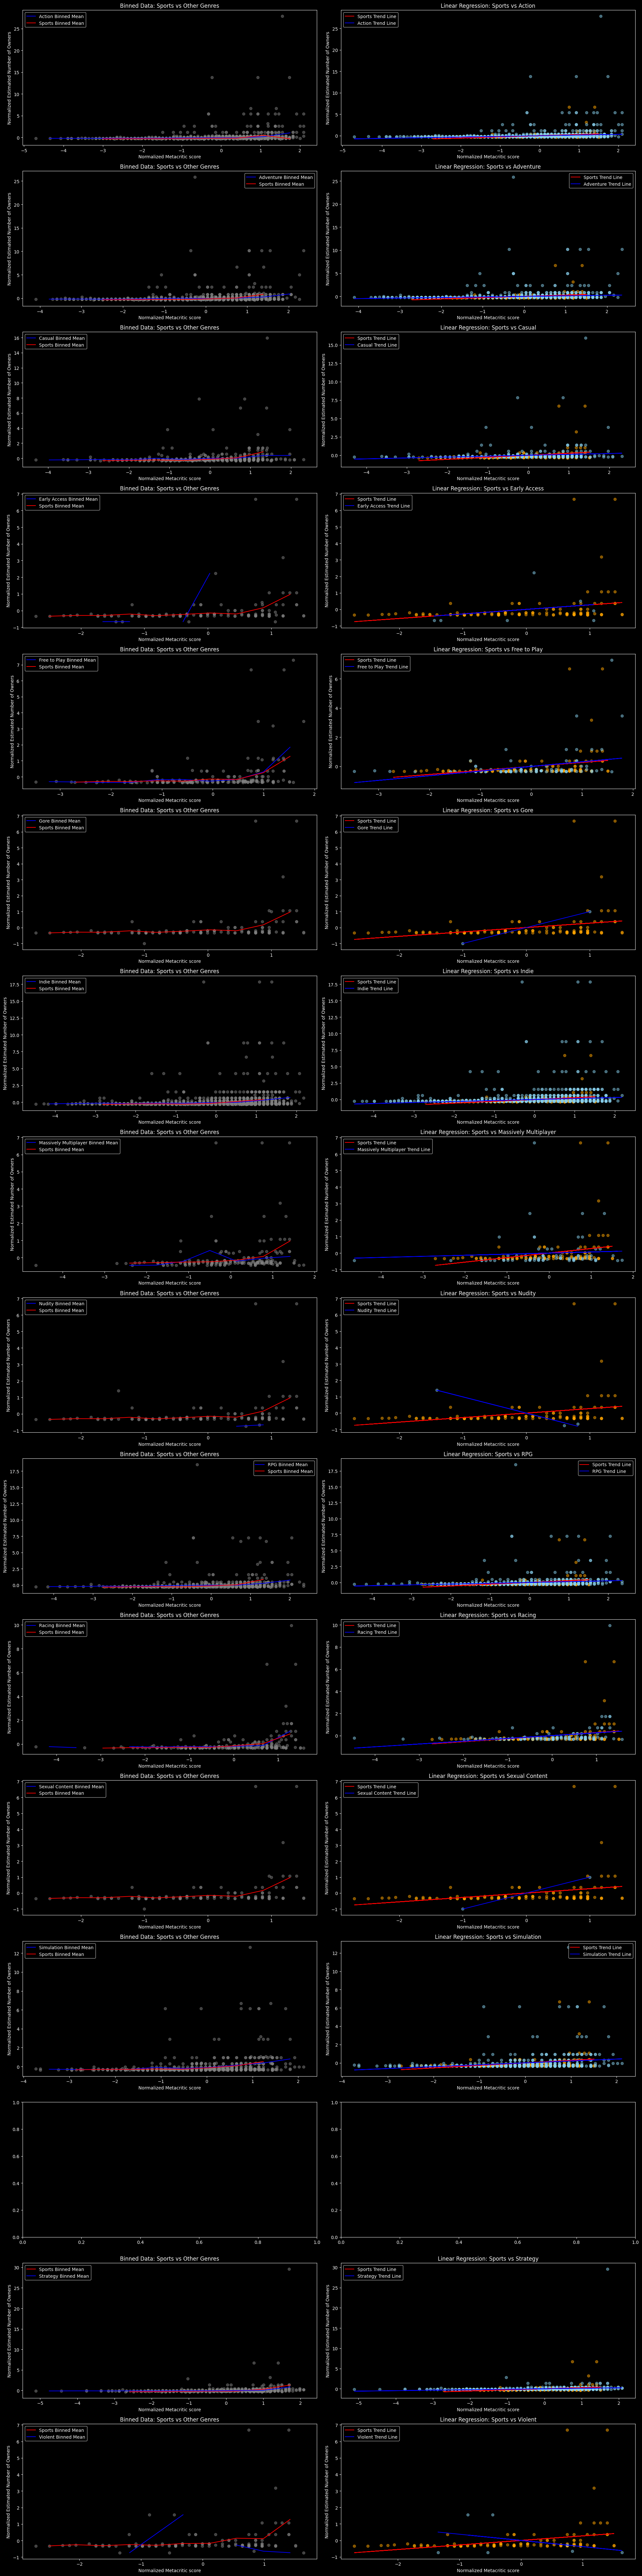

In [152]:
all_genres_data = pd.DataFrame() # do it separately so no accident change the original df

# aslo we do it seperate to avoid confusing with the previous plot
for index, genre in enumerate(generasDf):
    x = genre['Metacritic score'].values # Convert the Metacritic score column to a numpy arary
    y = genre['Estimated owners'].apply(lambda x: int(re.search(r'\d+', x).group())).values # Convert the estimated owners column to a numpy array

    scaler = StandardScaler() # Scale / normalize the data so that it is easier to see the correlation
    x = scaler.fit_transform(x.reshape(-1, 1)).flatten()
    y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # Create a dataframe for the genre
    genre_data = pd.DataFrame({
        'Normalized Metacritic score': x,
        'Normalized Estimated Number of Owners': y,
        'Genre': GenresList[index]
    })

    # if empty -> skip it 
    if (genre_data.empty):
      continue

    # Add the genre dataframe to the all genres dataframe
    all_genres_data = pd.concat([all_genres_data, genre_data])

plot_genre_comparisons(all_genres_data, 'Sports', GenresList)

## Binned Data: Sports vs Other Genres

### Sports vs Early Access

- Both sports and early access games show a flat binned mean trend, suggesting no significant relationship between Metacritic scores and the number of owners.

### Sports vs Free to Play

- Free-to-play games show an upward trend in the binned mean, indicating a potential positive relationship between Metacritic scores and ownership, whereas sports games remain flat.

### Sports vs Gore

- Sports games maintain a flat binned mean, while gore games exhibit a slight positive trend.
### Sports vs Indie

- Both indie and sports games have a flat trend, indicating a weak relationship between scores and ownership.
### Sports vs Massively Multiplayer

- Massively multiplayer games show a slight positive trend, while sports games show no trend.

### Sports vs Nudity

- Games with nudity content show a slight positive trend, while sports games continue to show no trend.

### Sports vs Racing

- Racing games have a flat trend similar to sports games, suggesting a weak relationship between scores and ownership.

### Sports vs RPG

- RPG games show a very slight positive trend, while sports games have a flat trend.

### Sports vs Sexual Content

- Sexual content games show a slight positive trend, while sports games remain flat.

### Sports vs Simulation

- Simulation games show a flat trend, similar to sports games.

### Sports vs Strategy

- Strategy games show a slightly positive trend, while sports games have a flat trend.

### Sports vs Violent

- Violent games show a more distinct positive trend, indicating a stronger relationship between scores and ownership compared to sports games.

## Linear Regression: Sports vs Other Genres
- The linear regression plots correspond with the binned data trends, with sports games generally showing a flat trend across all comparisons. -> Metacritic scores have little to no influence on the number of owners for sports games. In contrast, other genres sometimes show a positive trend, suggesting that higher scores may be more important for their ownership.

# From the analysis of these plots, we can infer that sports games have a consistent ownership pattern regardless of their critical reception, as indicated by their Metacritic scores. However, for genres such as free-to-play, gore, massively multiplayer, and violent games, the critical scores seem to have a more significant impact on ownership. This could be due to different audience expectations or the nature of the game market for these genres.

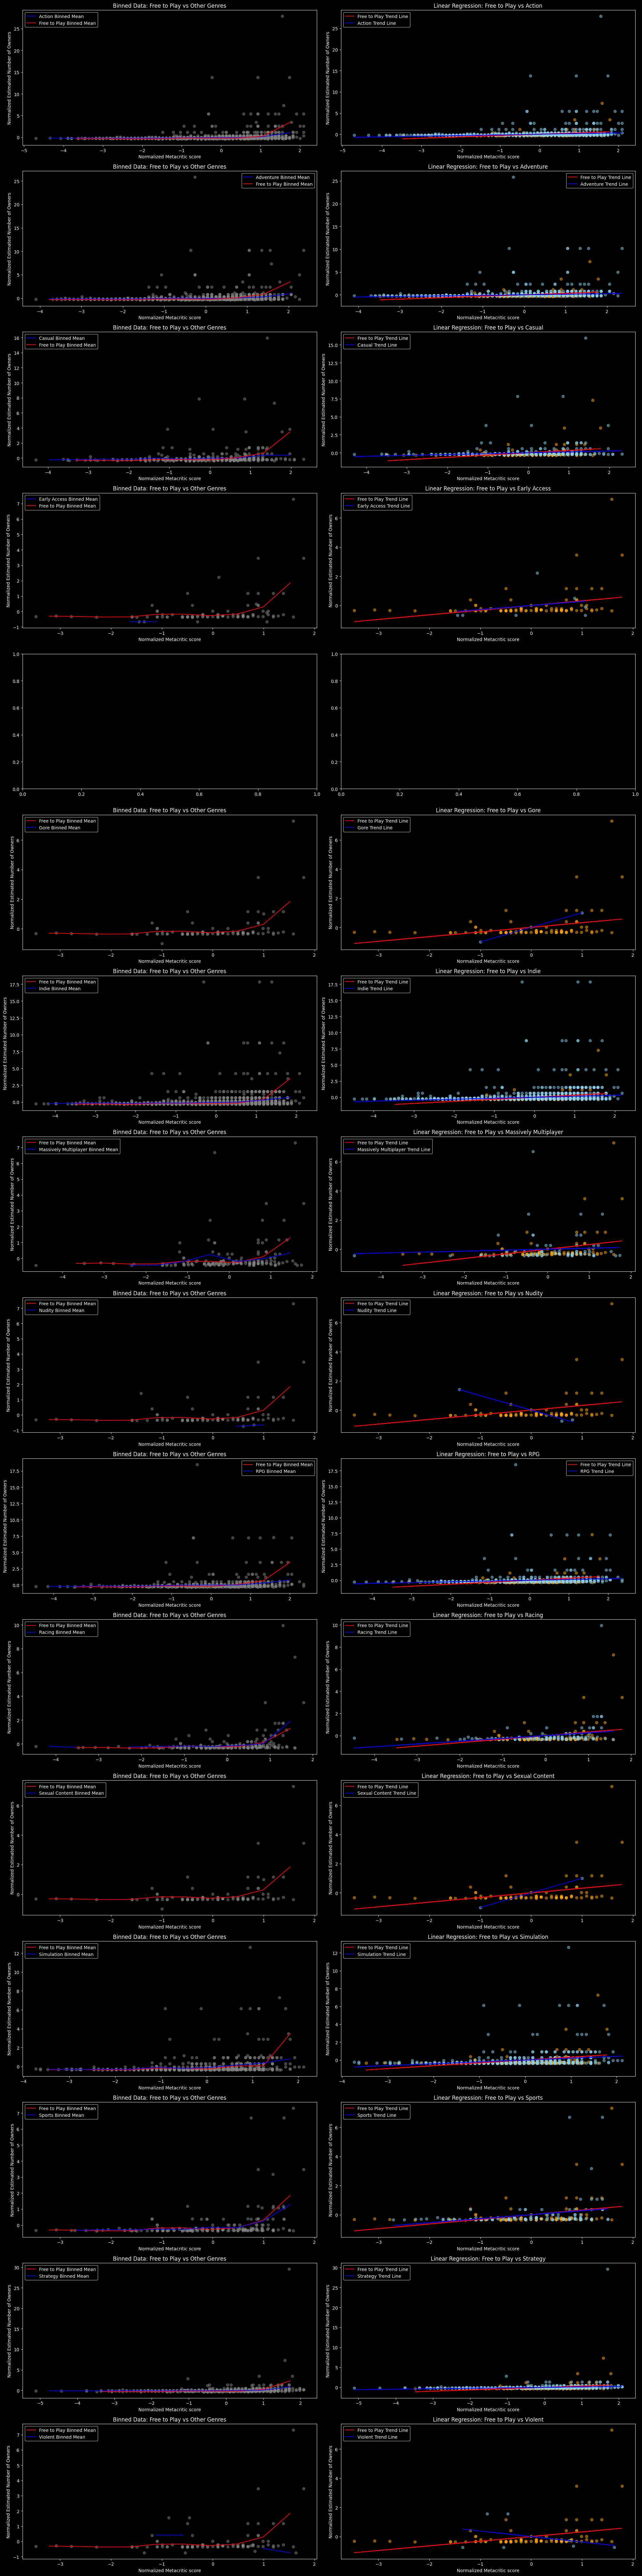

In [153]:
# free to play
plot_genre_comparisons(all_genres_data, 'Free to Play', GenresList)

## Binned Data: Free to Play vs Other Genres

### Free to Play vs Action

- Both genres show a relatively flat binned mean trend, suggesting a weak relationship between Metacritic scores and ownership.

### Free to Play vs Adventure

- The trend is similar to action, with both adventure and free-to-play showing a flat trend in binned means.

### Free to Play vs Casual

- Casual games show a slightly positive trend, whereas free-to-play games maintain a flat trend.

### Free to Play vs Early Access

- Early Access games show an upward trend in the binned mean, indicating that higher Metacritic scores may correspond to higher ownership, unlike the flat trend for free-to-play games.

### Free to Play vs Gore
- Gore games exhibit a slight positive trend in binned means, whereas free-to-play games show a flat trend.

### Free to Play vs Indie

- Both free-to-play and indie games show a flat binned mean trend, suggesting a weak relationship between scores and ownership.

### Free to Play vs Massively Multiplayer

- Massively multiplayer games demonstrate a slight positive trend, while free-to-play games have a flat trend.

### Free to Play vs Nudity

- Games featuring nudity show a slightly positive trend in binned means, while free-to-play games have a flat trend.

### Free to Play vs Racing

- Racing games show a positive trend, indicating that higher Metacritic scores may correspond to higher ownership. Free-to-play games show a flat trend.

### Free to Play vs RPG

- RPG games show a very slight positive trend, while free-to-play games have a flat trend.

### Free to Play vs Sexual Content

- Sexual content games show a slight positive trend, while free-to-play games maintain a flat trend.

### Free to Play vs Simulation

- Simulation games show a positive trend in binned means, while free-to-play games have a flat trend.

### Free to Play vs Sports

- Sports games show a flat trend, similar to free-to-play games.

### Free to Play vs Strategy

- Strategy games show a slight positive trend in binned means, whereas free-to-play games show a flat trend.

### Free to Play vs Violent

- Violent games show a distinct positive trend, suggesting a stronger relationship between scores and ownership compared to free-to-play games.

## Linear Regression: Free to Play vs Other Genres
- The linear regression trend lines for free-to-play games are generally flat across comparisons with other genres, reinforcing the notion that Metacritic scores do not significantly impact the number of owners for free-to-play games. In contrast, genres like early access, gore, massively multiplayer, and violent games show positive trend lines, indicating that higher Metacritic scores might be more influential for ownership in these categories.

# These analyses reveal that free-to-play games' ownership is less influenced by Metacritic scores, which could be due to the nature of free-to-play monetization strategies that rely less on initial purchases and more on in-game transactions or advertising. Meanwhile, certain other genres may attract players who are more influenced by critical reception and Metacritic scores.

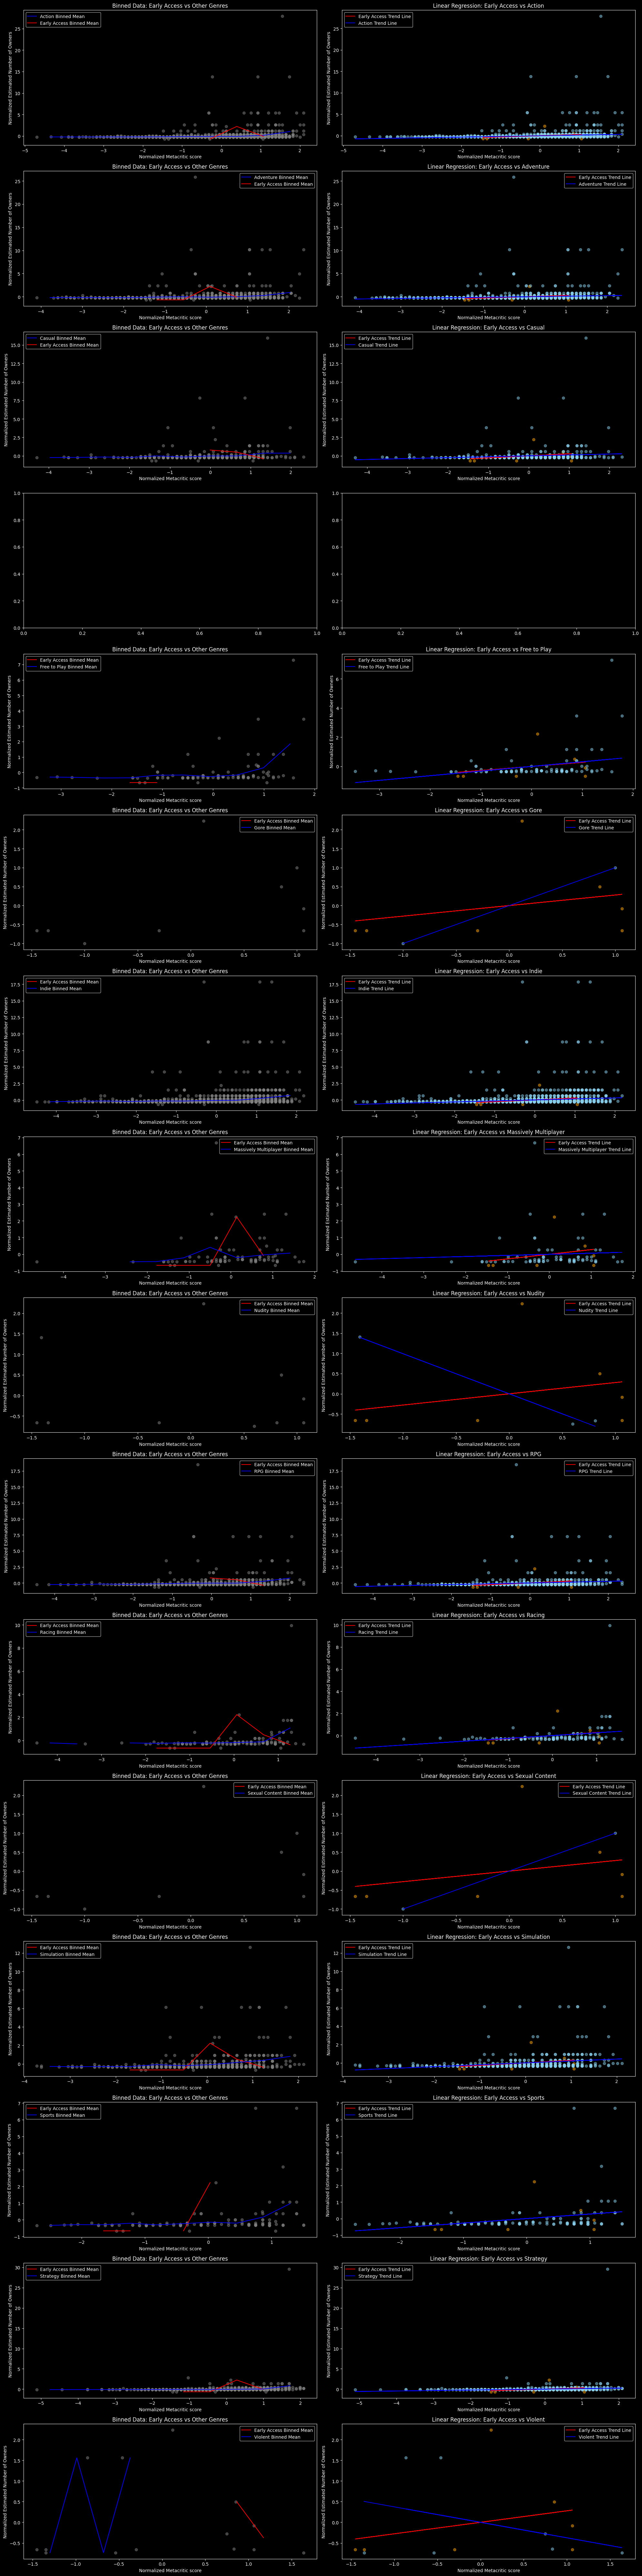

In [154]:
# Early Access
plot_genre_comparisons(all_genres_data, 'Early Access', GenresList)

## Binned Data: Early Access vs Other Genres

### Early Access vs Action

- The binned mean line for Early Access games shows a flat trend, implying little relationship between the Metacritic score and the number of owners. Action games follow a similar pattern.

### Early Access vs Adventure

- Adventure games have a slightly positive binned mean trend, whereas Early Access games remain flat.

### Early Access vs Casual
- Both genres show flat binned mean lines, suggesting no strong correlation between scores and ownership numbers.

### Early Access vs Free to Play
- Early Access games have a flat binned mean line, while Free to Play games exhibit an upward trend, suggesting a possible positive relationship with higher Metacritic scores.

### Early Access vs Gore
- Gore games and Early Access games both show a flat binned mean trend.

### Early Access vs Indie

- Indie games show a flat binned mean trend, similar to Early Access games.

### Early Access vs Massively Multiplayer

- The binned mean for Early Access games is flat, while Massively Multiplayer games show a slight peak, indicating some variability with scores.

### Early Access vs Nudity
- Early Access games continue to show a flat trend, while games featuring nudity have a variable binned mean trend with some positive direction.

### Early Access vs RPG

- Both Early Access and RPG genres show flat binned mean trends.

### Early Access vs Racing
- Racing games have a flat binned mean trend similar to Early Access games.

### Early Access vs Sexual Content

- Early Access games have a flat trend, while games with sexual content show a slight positive trend.

### Early Access vs Simulation
- Simulation games have a somewhat positive binned mean trend, while Early Access games remain flat.

### Early Access vs Sports

- Both genres show flat trends in their binned mean lines.

### Early Access vs Strategy

- Strategy games have a slight positive trend, while Early Access games have a flat trend.

### Early Access vs Violent

- Violent games show a flat trend, similar to Early Access games.

### Linear Regression: Early Access vs Other Genres
- The linear regression analysis largely mirrors the binned mean analysis:
    - Early Access games generally show a flat trend line, suggesting that the Metacritic scores do not have a significant linear impact on the number of owners.
    - In some comparisons, other genres show a slight positive slope in the linear regression trend lines (e.g., Free to Play, Simulation), which indicates a potential positive relationship between the scores and ownership.
    - In these plots, Early Access games consistently show that their Metacritic scores do not have a substantial impact on ownership. This could be because Early Access games are often in development, and players may be more interested in the potential of the game rather than its current state as reflected in Metacritic scores. 
    - In contrast, for other genres, especially Free to Play and Simulation, where we see a positive trend, the scores may play a more significant role in influencing ownership.

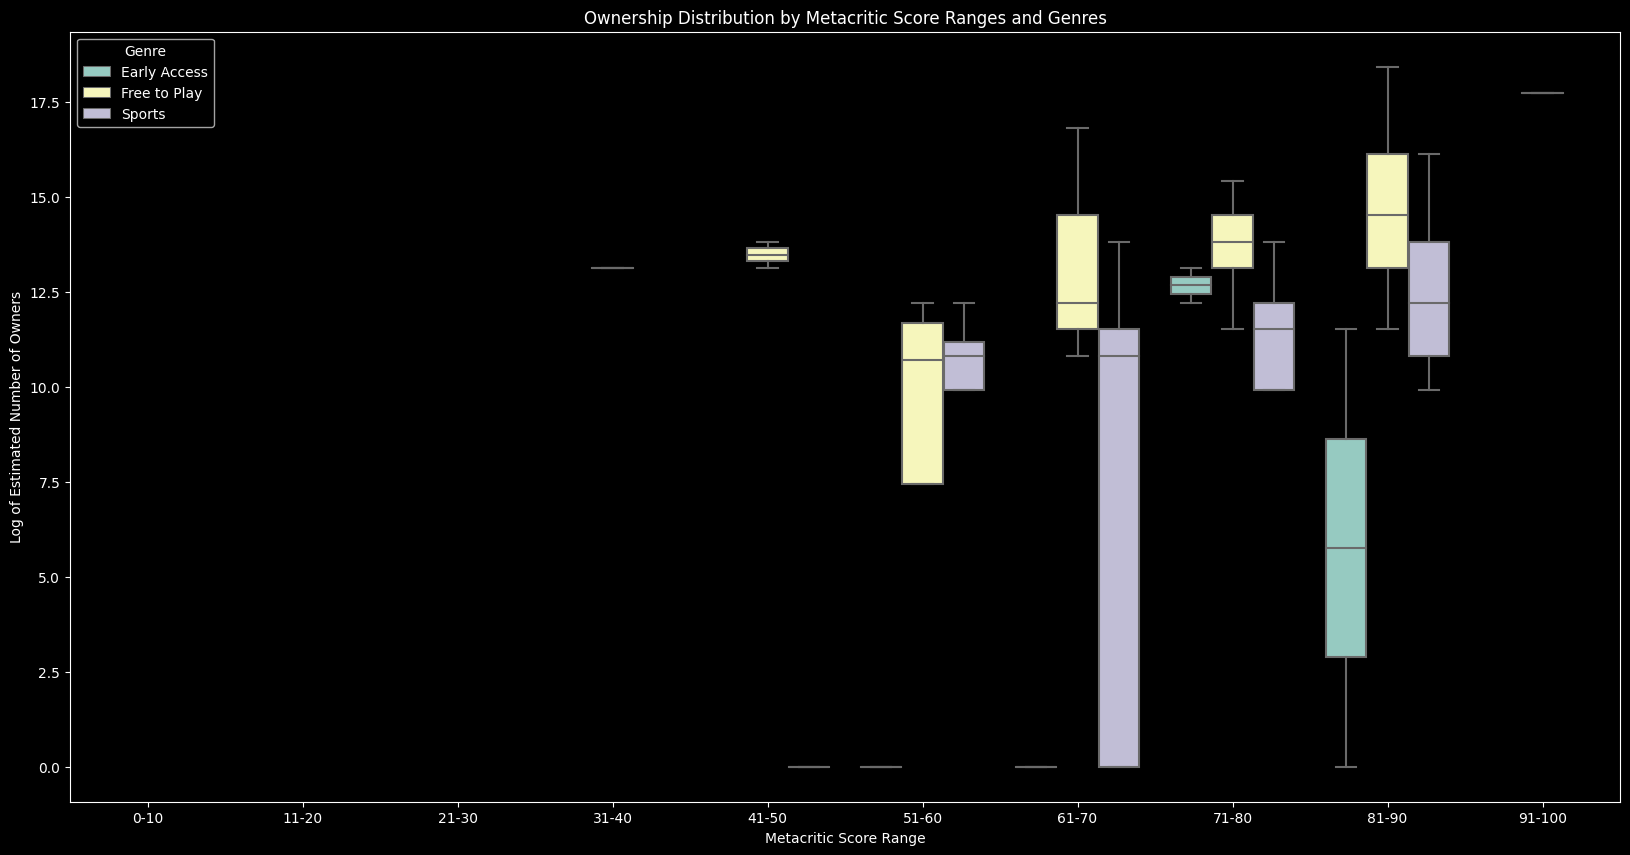

In [155]:
all_genres_data = pd.DataFrame() # do it separately so no accident change the original df

# aslo we do it seperate to avoid confusing with the previous plot
for index, genre in enumerate(generasDf):
    x = genre['Metacritic score'].values # Convert the Metacritic score column to a numpy arary
    y = genre['Estimated owners'].apply(lambda x: int(re.search(r'\d+', x).group())).values # Convert the estimated owners column to a numpy array

    # Create a dataframe for the genre
    genre_data = pd.DataFrame({
        'Metacritic score': x,
        'Estimated Number of Owners': y,
        'Genre': GenresList[index]
    })

    # if empty -> skip it 
    if (genre_data.empty):
      continue

    # Add the genre dataframe to the all genres dataframe
    all_genres_data = pd.concat([all_genres_data, genre_data])


# Define Metacritic score bins and labels
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
all_genres_data['Score Range'] = pd.cut(all_genres_data['Metacritic score'], bins=bins, labels=labels)

# Filter for specific genres (assuming the column name is 'Genre')
genres_of_interest = ['Free to Play', 'Early Access', 'Sports']
# Create a copy of the slice to avoid the SettingWithCopyWarning
filtered_data = all_genres_data[all_genres_data['Genre'].isin(genres_of_interest)].copy()

# Now you can safely transform the data without warnings
filtered_data['Log Estimated Number of Owners'] = np.log1p(filtered_data['Estimated Number of Owners'])

# Create box plots
plt.figure(figsize=(20, 10))  # Increased figure size for better clarity
sns.boxplot(x='Score Range', y='Log Estimated Number of Owners', hue='Genre', data=filtered_data, palette="Set3", showfliers=False)
plt.title('Ownership Distribution by Metacritic Score Ranges and Genres')
plt.xlabel('Metacritic Score Range')
plt.ylabel('Log of Estimated Number of Owners')
plt.legend(title='Genre')
plt.show()


## General Observations:
- Score Range Impact: All three genres show an increase in the median log of ownership as the Metacritic scores increase, especially noticeable in the highest ranges (81-100). This suggests that higher quality games, as perceived by critics, are likely to have larger ownership across genres.
- Genre Differences: There are distinct differences in the spread and median of ownership between the genres. Early Access games have high variability, reflecting the uncertain nature of games that are not fully developed. Free to Play games show a clear upward trend with score, highlighting the importance of game quality in attracting a player base. Sports games show a consistent ownership pattern that peaks in the mid-range scores, possibly indicating a dedicated audience.
- Outliers: The presence of outliers in the higher score ranges for all genres indicates that there are exceptional cases where games garner significantly higher ownership than the median.

# In summary, while the general trend across all genres suggests that higher-rated games tend to have higher ownership, the relationship between Metacritic scores and ownership is modulated by the genre, with Free to Play games showing the most pronounced trend. Early Access games have greater variability, and Sports games show a stable pattern with some unexpected peaks, indicating a complex relationship between game quality and popularity.

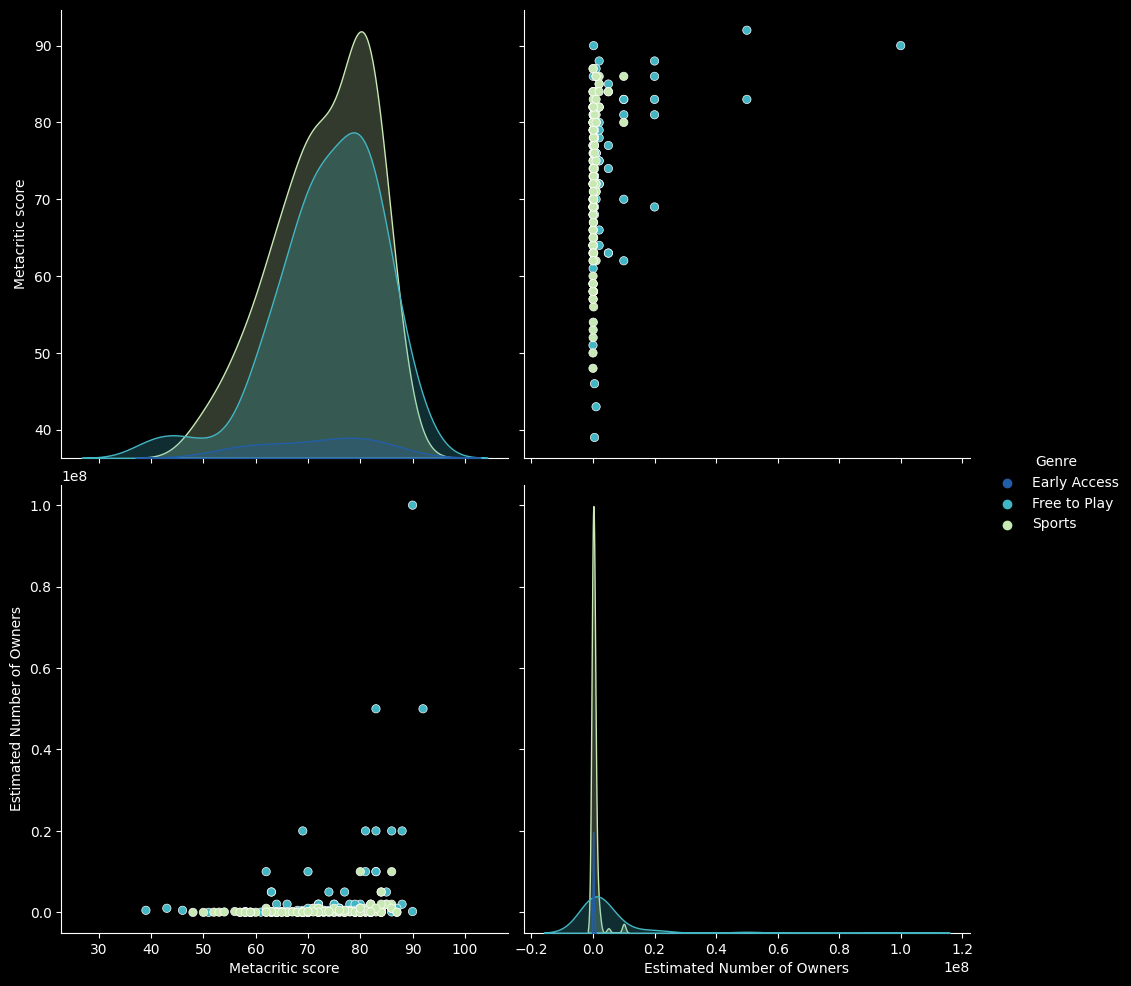

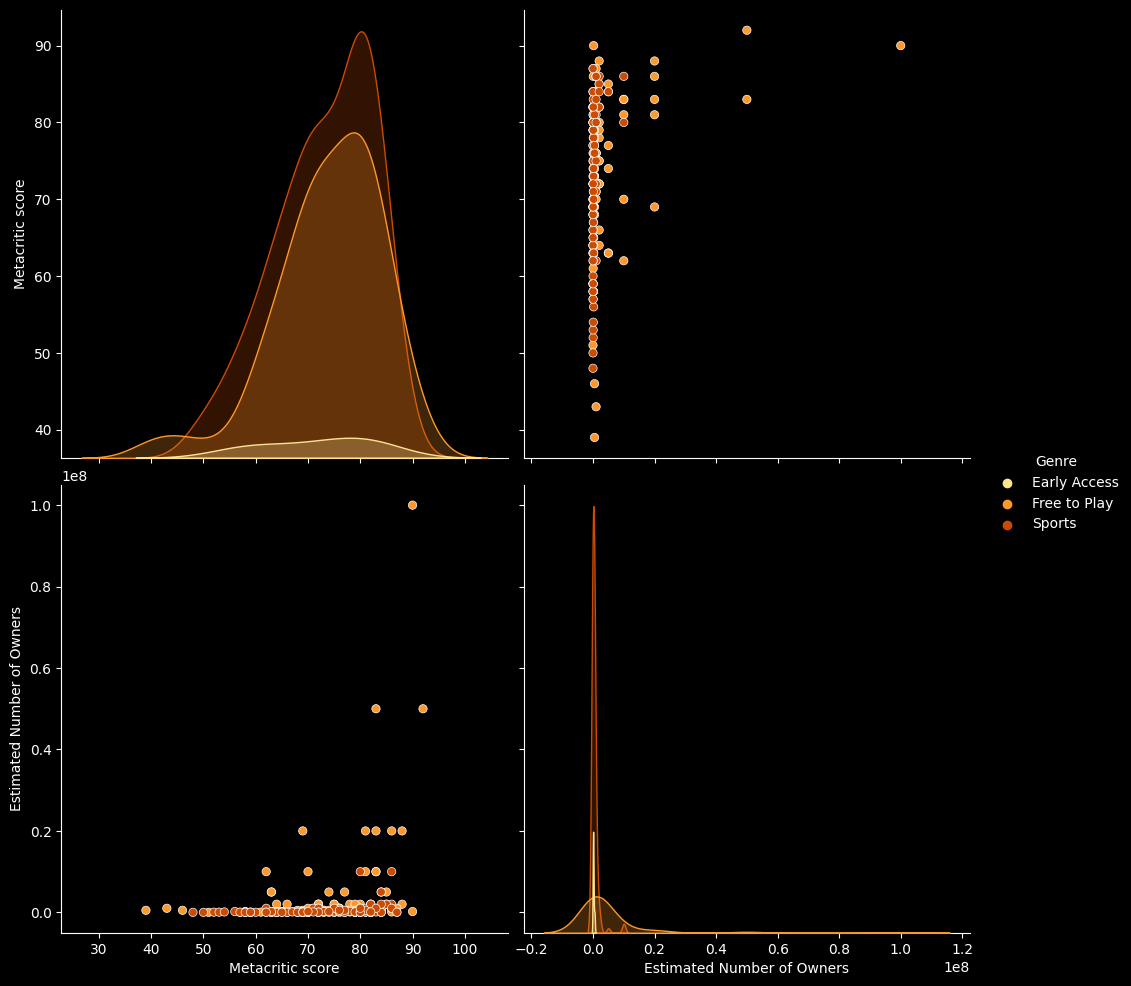

In [170]:
# Filter for specific genres (assuming the column name is 'Genre')
genres_of_interest = ['Free to Play', 'Early Access', 'Sports']

# Create a grid of scatter plots
sns.pairplot(all_genres_data[all_genres_data['Genre'].isin(genres_of_interest)], hue='Genre', palette="YlGnBu_r", height=5)
plt.show()

sns.pairplot(all_genres_data[all_genres_data['Genre'].isin(genres_of_interest)], hue='Genre', palette="YlOrBr", height=5)
plt.show()

## Density Plots (Left Side):

### Metacritic Score Density:

- The top-left plot shows the density distribution of Metacritic scores for the three genres. It looks like all three genres have similar distributions centered around a score in the 60s to 70s. There are some slight differences in the tails of the distributions, suggesting variations in the range of scores across genres.
  
### Estimated Number of Owners Density:

- The bottom-left plot shows the density distribution of the logarithm of the estimated number of owners. The distributions for Early Access and Sports genres appear to be skewed towards the lower end, indicating that most games in these genres have a smaller ownership base. The Free to Play genre shows a peak at the lower end as well but also presents a long tail towards the higher number of owners, suggesting that there are a few Free to Play games with a very large number of owners.

### Scatter Plots (Right Side):

- Metacritic Score vs. Ownership (Vertical Scatter Plot):
The top-right plot is a vertical scatter plot that correlates Metacritic scores with the number of owners for each genre. For all genres, as the Metacritic score increases, there's a tendency for the number of owners to increase as well, although this trend is more pronounced for the Free to Play genre. There are a few outliers, especially in the Free to Play genre, indicating some games with very high ownership regardless of the Metacritic score.

### Density of Ownership (Horizontal Scatter Plot):

- The bottom-right plot is a horizontal scatter plot that shows the distribution of ownership on the x-axis and the logarithm of the estimated number of owners on the y-axis. The plot is tightly clustered at the lower end for ownership, indicating that the majority of games across all genres have a relatively small number of owners. The spike for Free to Play games suggests that there are games in this genre that achieve exceptional success in terms of ownership.

## General Observations:

### Popularity vs. Quality: 

- There seems to be a positive correlation between Metacritic scores and the number of owners, particularly in the Free to Play genre, suggesting that higher-rated games tend to attract more players.
- Genre Differences: Free to Play games have a wider range of ownership numbers compared to Early Access and Sports, which may reflect the variability in the success of games within this genre.
- Skewed Ownership: The ownership numbers are heavily skewed for all genres, with most games accumulating a smaller number of owners and a few games becoming very popular.
- Outliers: Particularly in the Free to Play genre, there are outliers that significantly exceed the typical range of ownership, which could be d

## Hypothesis Question: 
    - For which genre is the Metacritic score most important in determining the number of owners?

## Hypothesis Question Answer:
  - Free to Play games show the strongest correlation between Metacritic scores and the number of owners, suggesting that game quality, as perceived by critics, is a significant factor in attracting players to this genre. In contrast, Early Access and Sports games show a weaker correlation between scores and ownership, indicating that other factors may be more important in determining the popularity of these genres.

## Limitations:
    - The data set is limited to games on Steam, which may not be representative of the entire gaming market.
    - The data seem not to be updated regularly, so the information may not be current.
    - 